In [1]:
# HPC
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, NullFormatter
from matplotlib.colors import SymLogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors, ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm as mplcm
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors

import cmocean
import cmocean.cm as cmo

# For surfvel data in tif files
import rasterio
from rasterio.transform import from_origin

# Paths and stuff
import os
import sys

import re
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
def plot_normal_new(
    x, y, data, *,
    cmap='RdBu_r', nbins=256,
    vmin=-10, vmax=10, center=0.0,
    cbar_ticks=None, cbar_label=None,
    fig=None, ax=None
):
    if ax is None:
        fig, ax = plt.subplots()

    # same norm for all panels
    norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

    # same level boundaries for all panels
    levels = np.linspace(vmin, vmax, nbins)

    im = ax.contourf(x, y, data,
                     levels=levels, cmap=cmap, norm=norm,
                     extend='both')

    # colorbar with the SAME boundaries (fixes spacing)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im, cax=cax,
                      boundaries=levels, spacing='proportional',
                      extend='both')
    if cbar_ticks is not None:
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels([f'{t:g}' for t in cbar_ticks])
    if cbar_label:
        cb.set_label(cbar_label)

    return ax

def read_field_from_tif(file_path):

    # Open the file
    with rasterio.open(file_path) as dataset:

        # # Print metadata information about the GeoTIFF file
        # print(dataset.meta)
        
        # Read the data from the first band (if the image has multiple bands)
        field = dataset.read(1)

        # SSG: Invert y-axis to match Ralf's surfvel data convention
        field = field[::-1]
        
        # # Accessing additional information
        # print(f"Width: {dataset.width}")
        # print(f"Height: {dataset.height}")
        # print(f"Number of Bands: {dataset.count}")

        return field

def slice_at_depth_linear(age, depths, z: float, *, return_weights=False):
    """
    Linearly interpolate a 2D slice from a 3D array `age` at normalized depth `z`.

    Parameters
    ----------
    age : (nz, ny, nx) array_like
        3D field with depth along axis 0.
    depths : (nz,) array_like
        Monotonically increasing normalized depths corresponding to axis 0, e.g. [0.0 ... 1.0].
    z : float
        Target normalized depth to sample.
    return_weights : bool, optional
        If True, also return (i1, i2, w1, w2).

    Returns
    -------
    slice2d : (ny, nx) ndarray
        Interpolated 2D slice at depth z.
    (optional) i1, i2, w1, w2 :
        Indices of the bracketing layers and their linear weights such that:
        slice = w1*age[i1] + w2*age[i2], with w1+w2=1.
    """
    age = np.asarray(age)
    depths = np.asarray(depths)

    if age.ndim != 3:
        raise ValueError("`age` must be (nz, ny, nx)")
    if depths.ndim != 1 or depths.shape[0] != age.shape[0]:
        raise ValueError("`depths` must be (nz,) matching age.shape[0]")
    if not np.all(np.diff(depths) >= 0):
        raise ValueError("`depths` must be monotonic increasing")

    # Handle boundaries & exact hits
    if z <= depths[0]:
        sl = age[0].astype(np.result_type(age.dtype, np.float64), copy=False)
        return (sl, 0, 0, 1.0, 0.0) if return_weights else sl
    if z >= depths[-1]:
        sl = age[-1].astype(np.result_type(age.dtype, np.float64), copy=False)
        return (sl, len(depths)-1, len(depths)-1, 1.0, 0.0) if return_weights else sl

    # Find bracketing indices
    i2 = int(np.searchsorted(depths, z, side="left"))
    if depths[i2] == z:
        sl = age[i2].astype(np.result_type(age.dtype, np.float64), copy=False)
        return (sl, i2, i2, 1.0, 0.0) if return_weights else sl

    i1 = i2 - 1
    x1, x2 = depths[i1], depths[i2]

    # Linear weights
    w2 = (z - x1) / (x2 - x1)
    w1 = 1.0 - w2

    # Interpolate
    # Promote dtype to avoid integer truncation
    out_dtype = np.result_type(age.dtype, np.float64)
    slice2d = (w1 * age[i1].astype(out_dtype, copy=False) +
               w2 * age[i2].astype(out_dtype, copy=False))

    if return_weights:
        return slice2d, i1, i2, float(w1), float(w2)
    return slice2d

In [3]:
# # DO NOT DELETE THIS CELL
# # IT IS FOR SANITY CHECK TO SEE WHICH SCALING FACTORS WERE ACTUALLY USED FOR AGE DATA
# # YOU MIGHT HAVE TO DECLARE SOME VARIABLES TO MAKE THIS CELL WORK

# H_orig = ds_bm5_orig["H"].data.copy()

# scale_uncert_factor_model = 1.0 - 0.25 * (H_orig - 2000.0) / (np.max(H_orig) - 2000.0)
# scale_uncert_factor_data = 1 + 4.0 * np.abs((ds_age_40kms["H"].data / H_orig) - 1)  
# scale_uncert_factor_data = np.nan_to_num(scale_uncert_factor_data, nan=5)

# ds_age_40kms['age_c_uncert'].data[40, 35, 20]**2 -\
# (scale_uncert_factor_model[35, 20]*ds_age_40kms['age_c'].data[40, 35, 20])**2 -\
# (scale_uncert_factor_data[35, 20]*ds_age_40kms['age_c_uncert_unbounded'].data[40, 35, 20])**2

In [74]:
modelPath = '/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/'
dataPath = '/scratch2/shreyas/GrIS_paleo_data/'

precip = xr.open_dataset("/home/shreyas/update_to_develop_sicopolis/sicopolis/sico_in/grl/grl_rembo_40_precip.nc")

ds_age  = xr.open_dataset(dataPath + 'RRRAG4_Greenland_1993_2013_01_age_grid.nc')
ds_age_correct = xr.open_dataset(dataPath + 'RRRAG4_Greenland_1993_2013_01_age_grid_corrected.nc')
ds_age_40kms = xr.open_dataset(dataPath + 'age_data_40kms.nc')

x_raw_data = ds_age_correct['xData'].data
y_raw_data = ds_age_correct['yData'].data

ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka_ser.nc')
ds_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka0011.nc')
ds_ser_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka_ser.nc')
ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka0011.nc')

ds_ser_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp/grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp_ser.nc')
ds_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp/grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp0007.nc')
ds_grl40_bm5_spinup02_smooth_100a = xr.open_dataset(modelPath + 'grl40_bm5_spinup02_smooth_100a/grl40_bm5_spinup02_smooth_100a0001.nc')
ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp/grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp0007.nc')

ds_bm5  = xr.open_dataset(dataPath + 'BedMachineGreenland-v5.nc')
ds_bm5['x'] = ds_bm5['x']*0.001
ds_bm5['y'] = ds_bm5['y']*0.001

ds_bm5_orig = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms_orig.nc")
ds_bm5_40kms = xr.open_dataset(dataPath + 'bm5_data_40kms.nc')

ds_bm5_40kms['x'] = ds_bm5_40kms['x']*0.001
ds_bm5_40kms['y'] = ds_bm5_40kms['y']*0.001

minimum_model_uncert = 0.0
minimum_total_uncert = 0.01
eta = (1.0 - minimum_total_uncert) * np.max(ds_bm5_orig["H"].data) / 2000.0
H_uncert_model = (1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*eta) * (200.0 + ds_bm5_orig["H"].data) * (ds_bm5_orig["H"].data < 2000.0)
H_uncert_model[ds_bm5_orig["H"].data >= 2000.0] = minimum_model_uncert*ds_bm5_orig["H"].data[ds_bm5_orig["H"].data >= 2000.0]
H_uncert_data = np.sqrt(ds_bm5_40kms["H_uncert"].data**2 - H_uncert_model**2)

H_data_nan = ds_bm5_40kms["H"].data.copy()
H_data_nan[H_data_nan == 0.0] = np.nan

H_uncert_total_nan = ds_bm5_40kms["H_uncert"].data.copy()
H_uncert_total_nan[H_uncert_total_nan == 0.0] = np.nan
H_uncert_data_nan = H_uncert_data.copy()
H_uncert_data_nan[H_uncert_data_nan == 0.0] = np.nan
H_uncert_model_nan = H_uncert_model.copy()
H_uncert_model_nan[H_uncert_model == 0.0] = np.nan

zs_data_fullres = ds_bm5["surface"].data.copy()
zl_data_fullres = ds_bm5["bed"].data.copy()
H_data_fullres_nan = ds_bm5["thickness"].data.copy()
H_uncert_data_fullres_nan = ds_bm5["errbed"].data.copy()

H_data_fullres_nan[H_data_fullres_nan == 0.0] = np.nan
H_uncert_data_fullres_nan[H_uncert_data_fullres_nan == 0.0] = np.nan

vs_data_fullres = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vs_v1.tif")
vx_data_fullres = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vx_v1.tif")
vx_uncert_data_fullres = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_ex_v1.tif")
vy_data_fullres = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vy_v1.tif")
vy_uncert_data_fullres = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_ey_v1.tif")

vs_data_fullres_nan = vs_data_fullres.copy()
vx_data_fullres_nan = vx_data_fullres.copy()
vy_data_fullres_nan = vy_data_fullres.copy()
vx_uncert_data_fullres_nan = vx_uncert_data_fullres.copy()
vy_uncert_data_fullres_nan = vy_uncert_data_fullres.copy()

vs_data_fullres_nan[vs_data_fullres_nan < -1.e9] = np.nan
vx_data_fullres_nan[vx_data_fullres_nan < -1.e9] = np.nan
vy_data_fullres_nan[vy_data_fullres_nan < -1.e9] = np.nan
vx_uncert_data_fullres_nan[vx_uncert_data_fullres_nan < -1.e9] = np.nan
vy_uncert_data_fullres_nan[vy_uncert_data_fullres_nan < -1.e9] = np.nan

ds_fullres = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vs_v1.nc")
xs_fullres = ds_fullres["x"].data / 1000.0
ys_fullres = ds_fullres["y"].data / 1000.0

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data_40_orig = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms_orig.nc")
ds_surfvel_data_40km = xr.open_dataset(dataPath + 'surfvel_data_40kms.nc')
ds_surfvel_model_40km_tuned = xr.open_dataset("/home/shreyas/update_to_develop_sicopolis/sicopolis_optim_SVC_3point5_50_new_pickup_2/sico_out/N_grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp/0007.nc")

factor = 1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*0.5
model_uncert_vx = factor*np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_vy = factor*np.abs(ds_surfvel_data_40km["vy"].data)

H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

vs_orig_data = ds_surfvel_data_40km["vs_orig"].data
vs_data = ds_surfvel_data_40km["vs"].data
vx_data = ds_surfvel_data_40km["vx"].data
vy_data = ds_surfvel_data_40km["vy"].data

vx_data_uncert_data = ds_surfvel_data_40km["vx_uncert_unbounded"].data
vy_data_uncert_data = ds_surfvel_data_40km["vy_uncert_unbounded"].data
vx_uncert_data = ds_surfvel_data_40km["vx_uncert_50"].data
vy_uncert_data = ds_surfvel_data_40km["vy_uncert_50"].data

vs_model_tuned = (ds_surfvel_model_40km_tuned['vx_s_g'].data**2 + ds_surfvel_model_40km_tuned['vy_s_g'].data**2)**0.5
vx_model_tuned = ds_surfvel_model_40km_tuned['vx_s_g'].data
vy_model_tuned = ds_surfvel_model_40km_tuned['vy_s_g'].data

mask_land_tuned = ds_surfvel_model_40km_tuned["mask"].data.copy()
mask_land_tuned[mask_land_tuned == 0] = -1
mask_land_tuned[mask_land_tuned == 1] = -1
mask_land_tuned[mask_land_tuned == 2] = 1
mask_land_tuned[mask_land_tuned == 3] = 1

mask_ice_tuned = ds_surfvel_model_40km_tuned["mask"].data.copy()
mask_ice_tuned[mask_ice_tuned == 0] = -1
mask_ice_tuned[mask_ice_tuned == 3] = -1
mask_ice_tuned[mask_ice_tuned == 1] = 1
mask_ice_tuned[mask_ice_tuned == 2] = 1

vs_model_tuned_nan = vs_model_tuned.copy()
vs_model_tuned_nan[vs_model_tuned_nan == 0.0] = np.nan
vs_data_nan = vs_data.copy()
vs_data_nan[vs_data_nan == 0.0] = np.nan

vx_model_tuned_nan = vx_model_tuned.copy()
vx_model_tuned_nan[vx_model_tuned_nan == 0.0] = np.nan
vx_data_nan = vx_data.copy()
vx_data_nan[vx_data_nan == 0.0] = np.nan

vy_model_tuned_nan = vy_model_tuned.copy()
vy_model_tuned_nan[vy_model_tuned_nan == 0.0] = np.nan
vy_data_nan = vy_data.copy()
vy_data_nan[vy_data_nan == 0.0] = np.nan

vx_uncert_data_nan = vx_uncert_data.copy()
vx_uncert_data_nan[vx_uncert_data_nan == 1.0] = np.nan
vy_uncert_data_nan = vy_uncert_data.copy()
vy_uncert_data_nan[vy_uncert_data_nan == 1.0] = np.nan

vx_data_uncert_data_nan = vx_data_uncert_data.copy()
vx_data_uncert_data_nan[vx_data_uncert_data_nan == 1.0] = np.nan
vy_data_uncert_data_nan = vy_data_uncert_data.copy()
vy_data_uncert_data_nan[vy_data_uncert_data_nan == 1.0] = np.nan

model_uncert_vx_nan = model_uncert_vx.copy()
model_uncert_vx_nan[model_uncert_vx_nan == 0.0] = np.nan
model_uncert_vy_nan = model_uncert_vy.copy()
model_uncert_vy_nan[model_uncert_vy_nan == 0.0] = np.nan

no_nudging_mask = ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp["mask"].data
no_nudging_mask_nan = no_nudging_mask.copy()
no_nudging_mask_nan = no_nudging_mask_nan.astype(float)
no_nudging_mask_nan[(no_nudging_mask_nan != 0) & (no_nudging_mask_nan != 3)] = np.nan
no_nudging_mask_nan[(no_nudging_mask_nan == 0) | (no_nudging_mask_nan == 3)] = 1

nudging_mask = ds_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp["mask"].data
nudging_mask_nan = nudging_mask.copy()
nudging_mask_nan = nudging_mask_nan.astype(float)
nudging_mask_nan[(nudging_mask_nan != 0) & (nudging_mask_nan != 3)] = np.nan
nudging_mask_nan[(nudging_mask_nan == 0) | (nudging_mask_nan == 3)] = 1

data_mask = vs_data != 0.0
data_mask_nan = data_mask.copy()
data_mask_nan = data_mask_nan.astype(float)
data_mask_nan[data_mask_nan == 0.0] = np.nan

H_data = ds_bm5_orig["H"].data
H_data_nan = H_data.copy()
H_data_nan[H_data_nan == 0.0] = np.nan

H_nudged = ds_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp["H"].data
H_nudged_nan = H_nudged.copy()
H_nudged_nan[H_nudged_nan == 0.0] = np.nan

H_not_nudged = ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp["H"].data
H_not_nudged_nan = H_not_nudged.copy()
H_not_nudged_nan[H_not_nudged_nan == 0.0] = np.nan

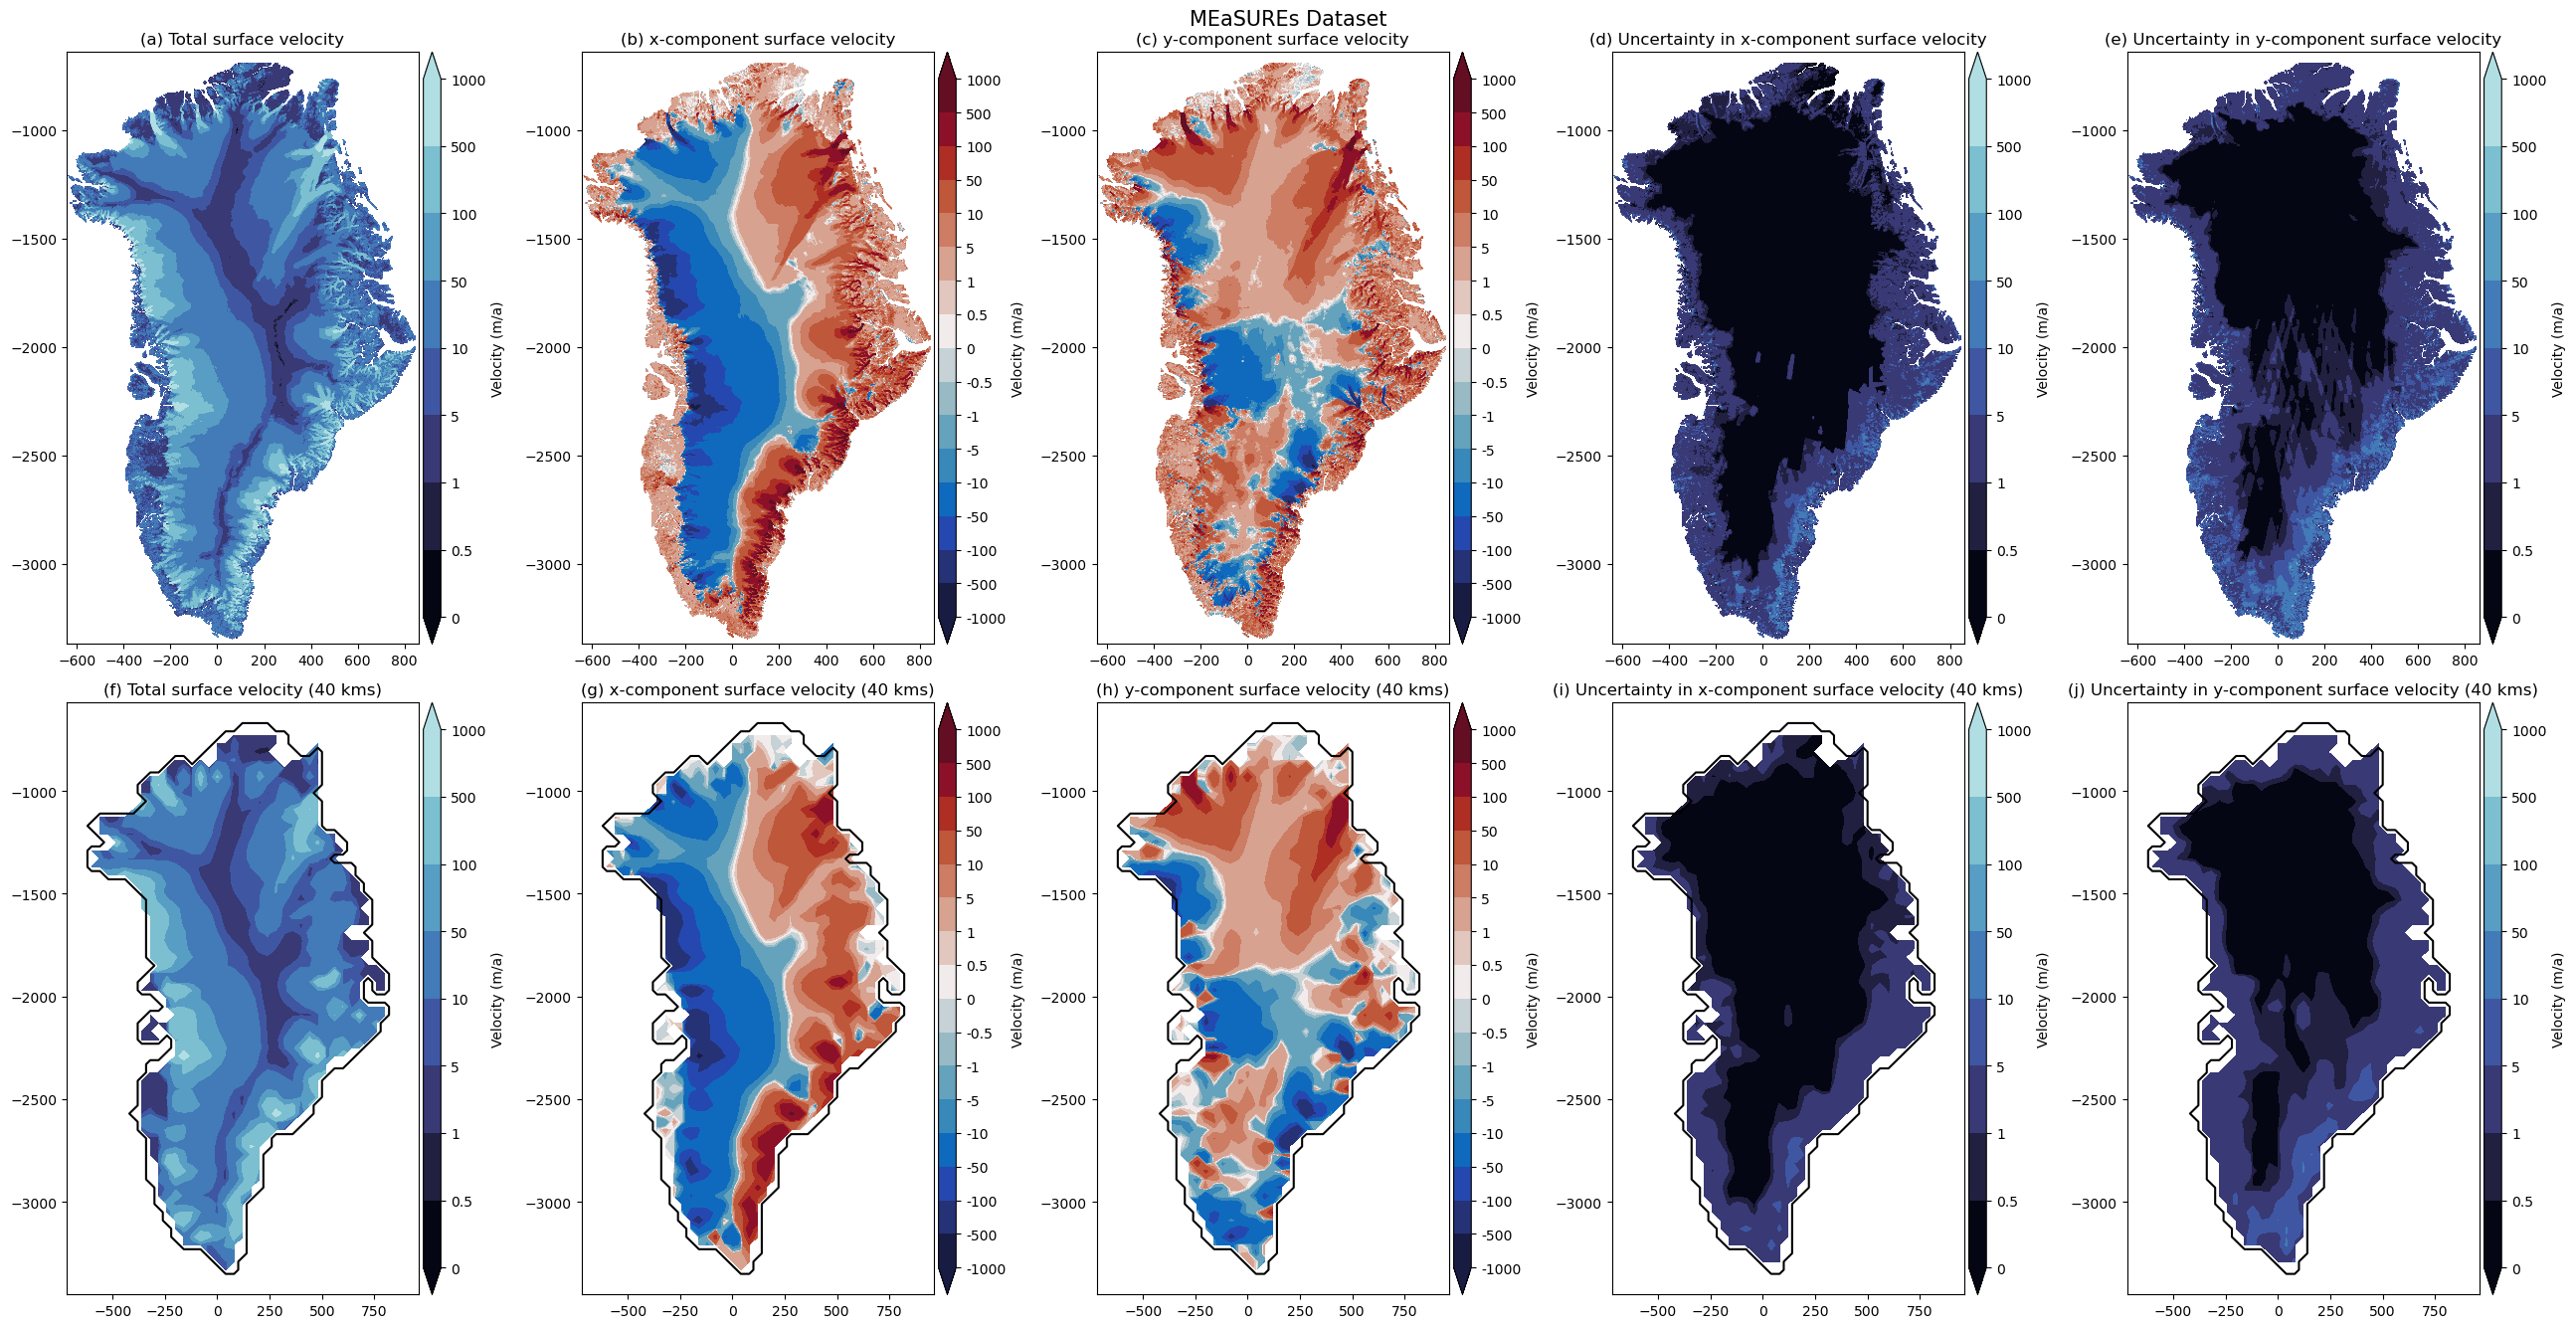

In [5]:
n_rows, n_cols = 2, 5
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

# Define discrete bin edges
levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# Use cmocean speed colormap
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 0].contourf(
    xs_fullres,
    ys_fullres,
    vs_data_fullres_nan,  # or vs_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 0].set_title("(a) Total surface velocity")

# --- Define levels (notice that we skip 0, and keep ±0.5 as the neutral region)
levels = [-1000.0, -500.0, -100.0, -50.0, -10.0, -5.0, -1.0, -0.5, 0.0,
          0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.balance
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 1].contourf(
    xs_fullres,
    ys_fullres,
    vx_data_fullres_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 1].set_title("(b) x-component surface velocity")

# --- Define levels (notice that we skip 0, and keep ±0.5 as the neutral region)
levels = [-1000.0, -500.0, -100.0, -50.0, -10.0, -5.0, -1.0, -0.5, 0.0,
          0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.balance
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 2].contourf(
    xs_fullres,
    ys_fullres,
    vy_data_fullres_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 2].set_title("(c) y-component surface velocity")

levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 3].contourf(
    xs_fullres,
    ys_fullres,
    vx_uncert_data_fullres_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 3].set_title("(d) Uncertainty in x-component surface velocity")

levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 4].contourf(
    xs_fullres,
    ys_fullres,
    vy_uncert_data_fullres_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 4].set_title("(e) Uncertainty in y-component surface velocity")

# Define discrete bin edges
levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# Use cmocean speed colormap
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[1, 0].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vs_data_nan,  # or vs_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 0].set_title("(f) Total surface velocity (40 kms)")

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# --- Define levels (notice that we skip 0, and keep ±0.5 as the neutral region)
levels = [-1000.0, -500.0, -100.0, -50.0, -10.0, -5.0, -1.0, -0.5, 0.0,
          0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.balance
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[1, 1].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vx_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 1].set_title("(g) x-component surface velocity (40 kms)")

# --- Define levels (notice that we skip 0, and keep ±0.5 as the neutral region)
levels = [-1000.0, -500.0, -100.0, -50.0, -10.0, -5.0, -1.0, -0.5, 0.0,
          0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.balance
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[1, 2].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vy_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 2].set_title("(h) y-component surface velocity (40 kms)")

levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[1, 3].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vx_data_uncert_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 3].set_title("(i) Uncertainty in x-component surface velocity (40 kms)")

levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[1, 4].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vy_data_uncert_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[1, 4].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 4].set_title("(j) Uncertainty in y-component surface velocity (40 kms)")

plt.suptitle("MEaSUREs Dataset", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/MEaSUREs.png")

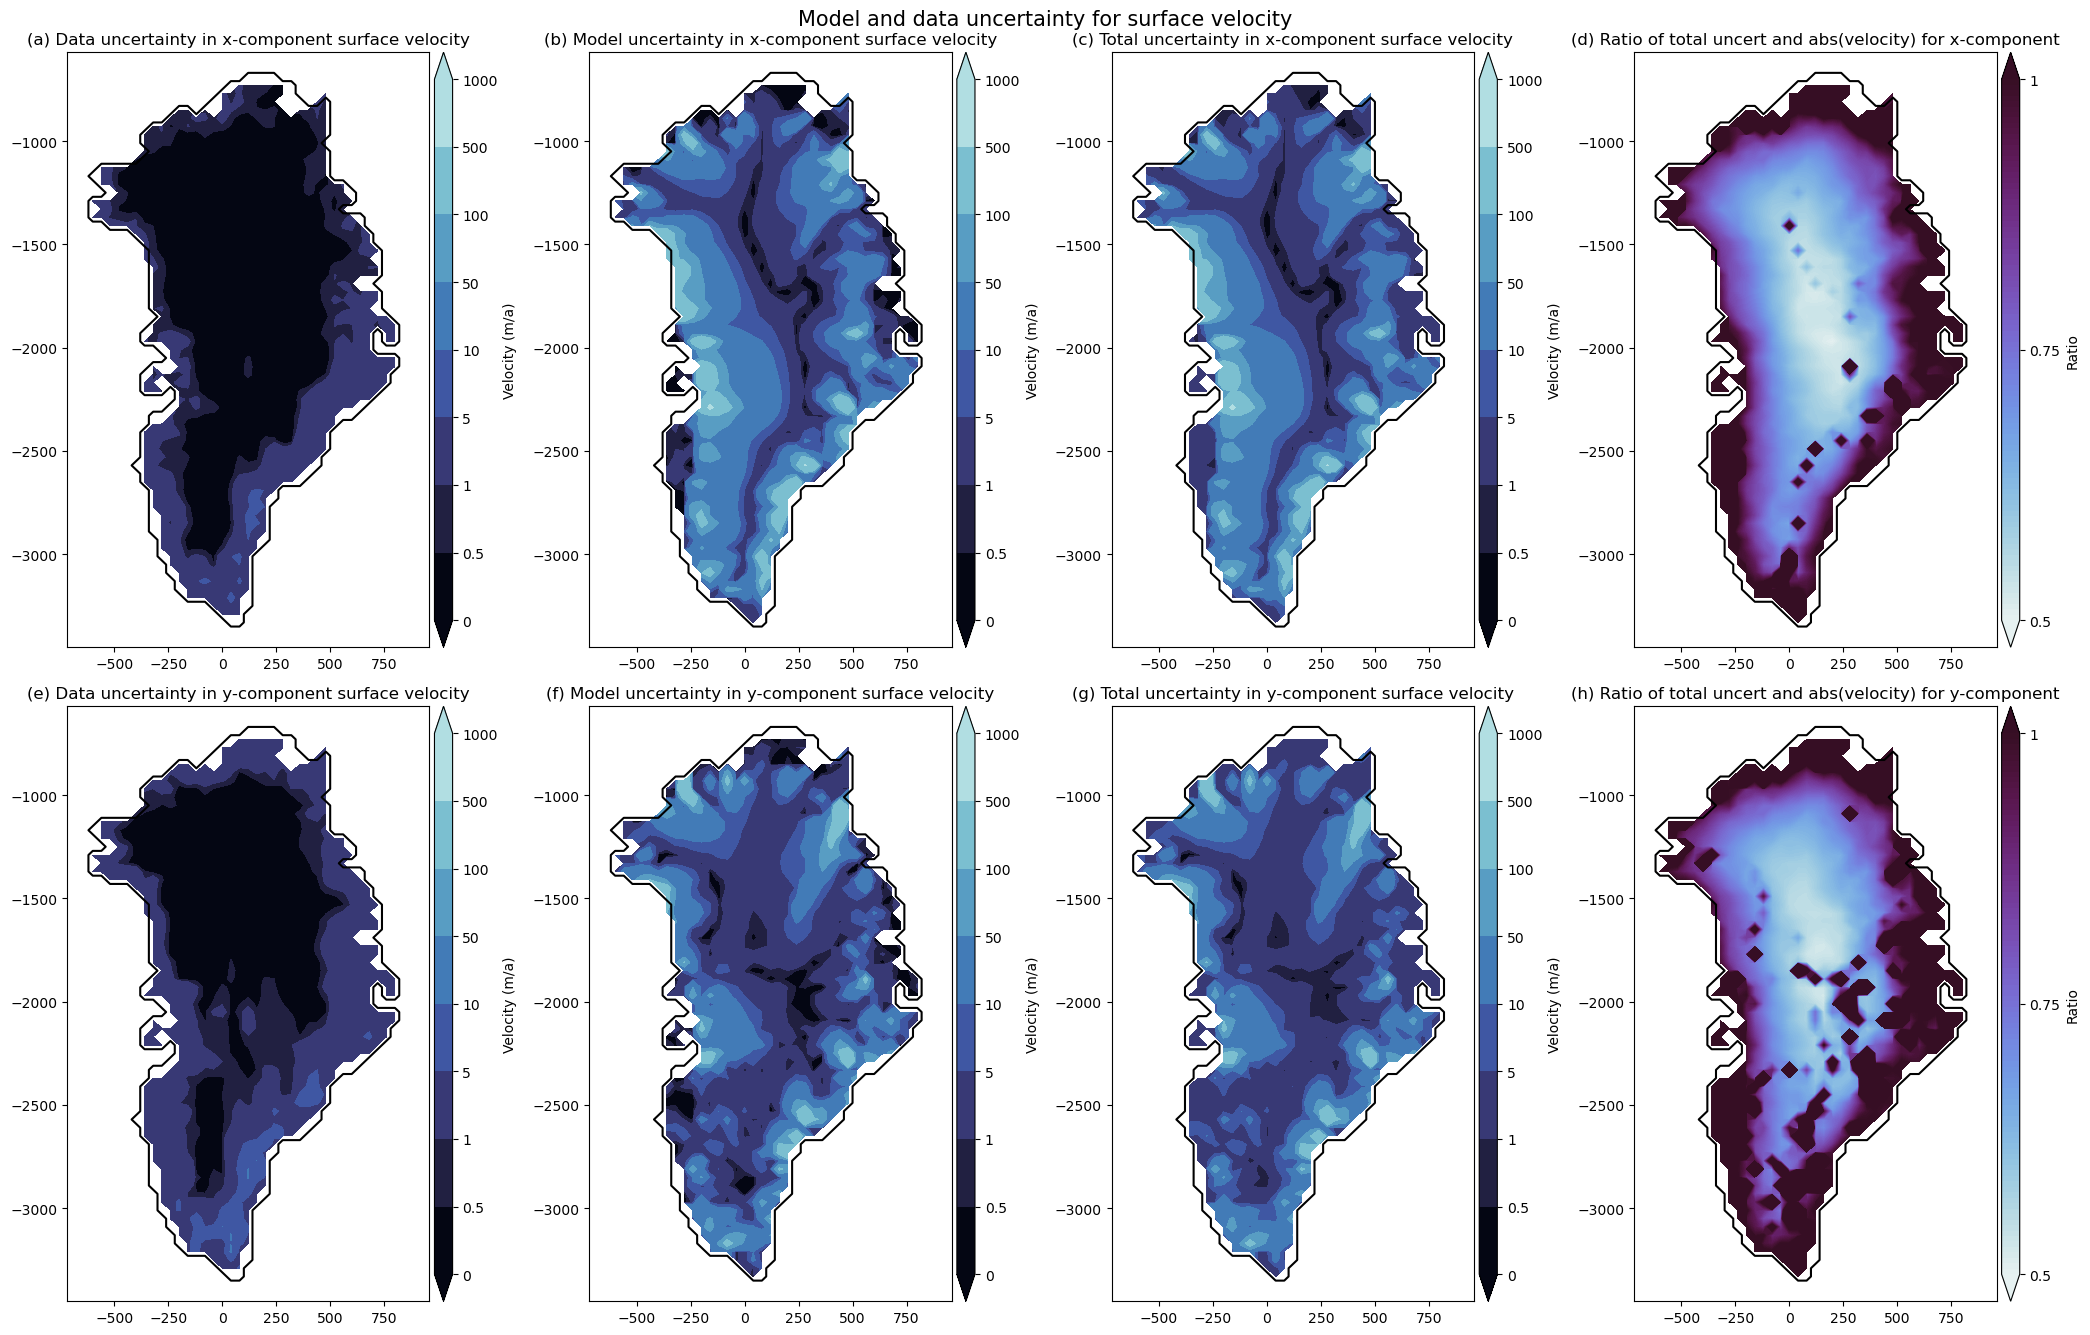

In [6]:
n_rows, n_cols = 2, 4
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.25)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 0].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vx_data_uncert_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 0].set_title("(a) Data uncertainty in x-component surface velocity")

# Plot discrete contourf on the existing ax
im = ax[0, 1].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    model_uncert_vx_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 1].set_title("(b) Model uncertainty in x-component surface velocity")

# Plot discrete contourf on the existing ax
im = ax[0, 2].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vx_uncert_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 2].set_title("(c) Total uncertainty in x-component surface velocity")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                vx_uncert_data_nan / np.abs(vx_data_nan),
                cmap = cmo.dense, nbins = 100, vmin = 0.5, vmax = 1.0, center = 0.75,
                fig = fig, ax = ax[0, 3],
                cbar_label = r"Ratio", cbar_ticks=[0.5, 0.75, 1.0])

ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[0, 3].set_title("(d) Ratio of total uncert and abs(velocity) for x-component")

# Plot discrete contourf on the existing ax
im = ax[1, 0].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vy_data_uncert_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 0].set_title("(e) Data uncertainty in y-component surface velocity")

# Plot discrete contourf on the existing ax
im = ax[1, 1].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    model_uncert_vy_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 1].set_title("(f) Model uncertainty in y-component surface velocity")

# Plot discrete contourf on the existing ax
im = ax[1, 2].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vy_uncert_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[1, 2].set_title("(g) Total uncertainty in y-component surface velocity")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                vy_uncert_data_nan / np.abs(vy_data_nan),
                cmap = cmo.dense, nbins = 100, vmin = 0.5, vmax = 1.0, center = 0.75,
                fig = fig, ax = ax[1, 3],
                cbar_label = r"Ratio", cbar_ticks=[0.5, 0.75, 1.0])

ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 3].set_title("(h) Ratio of total uncert and abs(velocity) for y-component")

plt.suptitle("Model and data uncertainty for surface velocity", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/MEaSUREs_model_data_uncert.png")

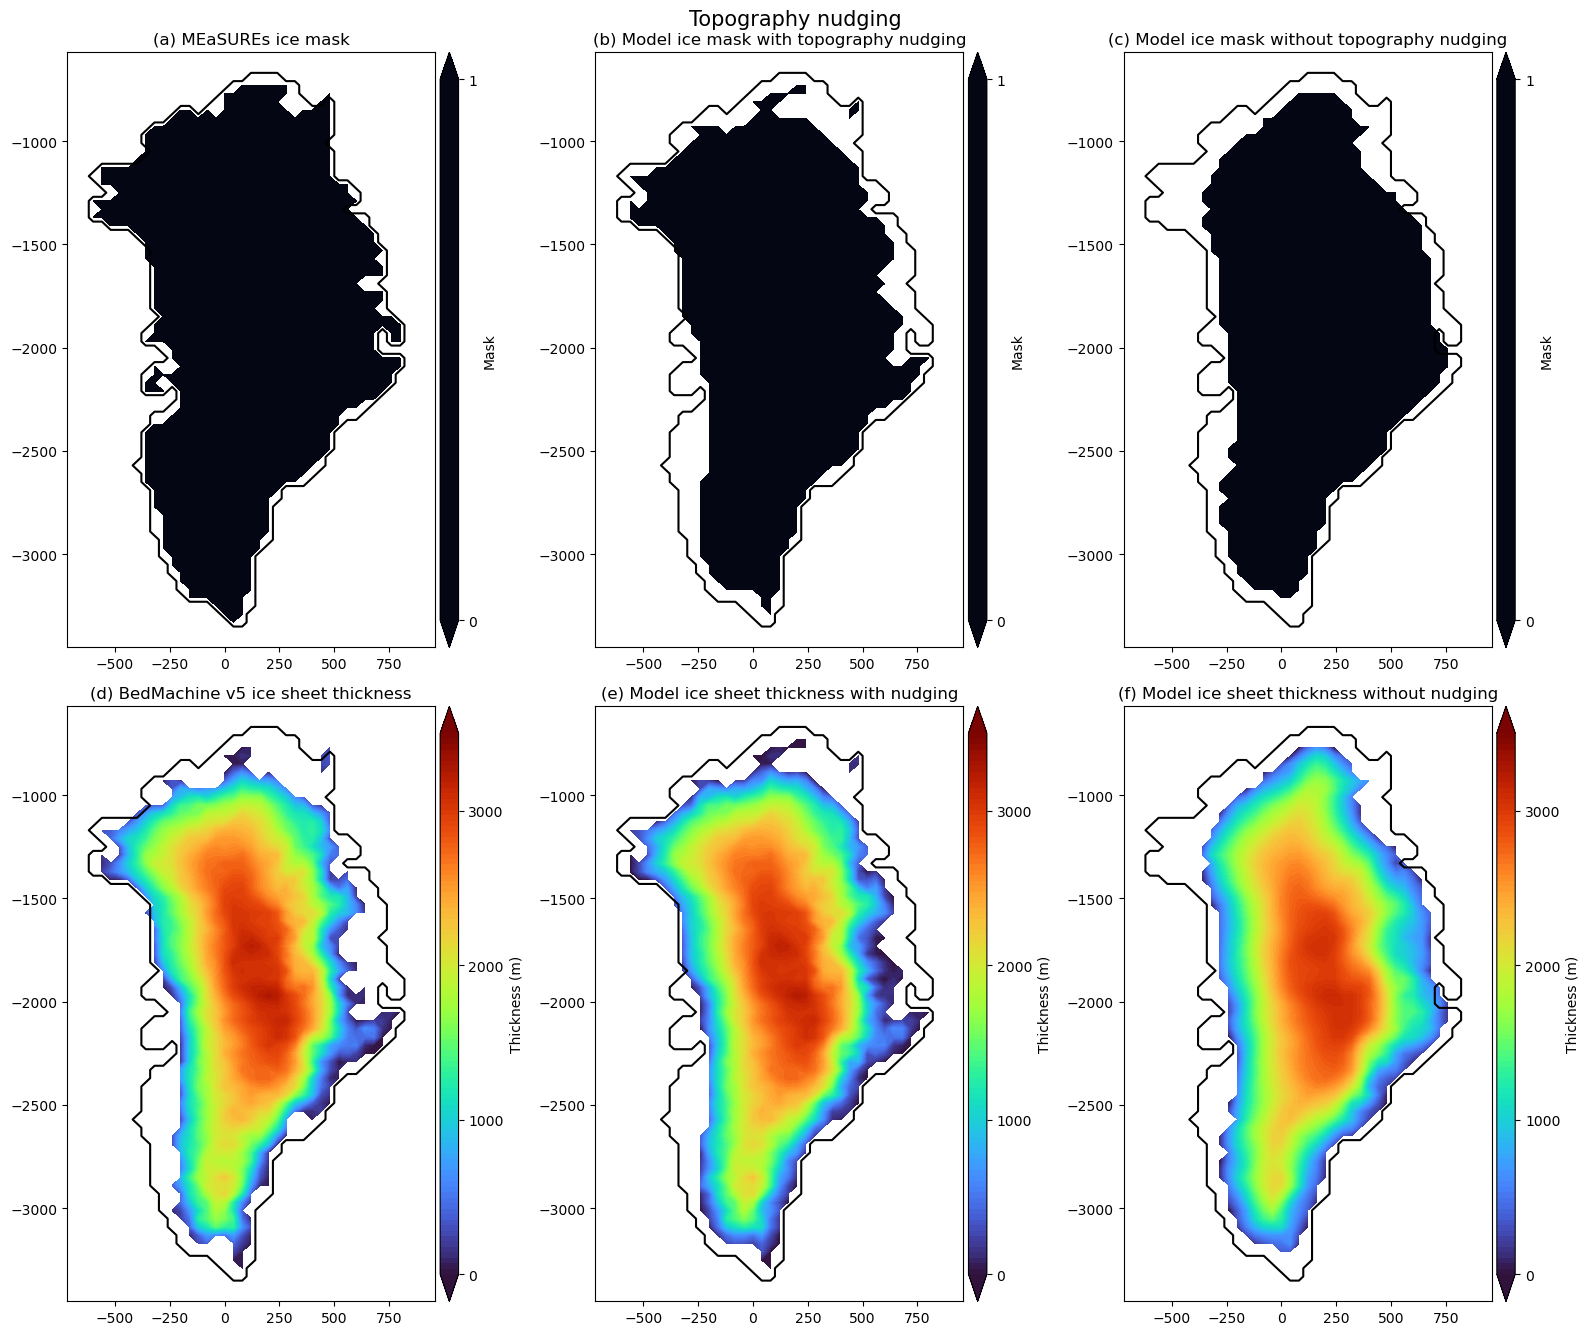

In [7]:
n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

levels = [0.0, 1.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 0].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    data_mask_nan,
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Mask")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 0].set_title("(a) MEaSUREs ice mask")

# Plot discrete contourf on the existing ax
im = ax[0, 1].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    nudging_mask_nan,
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Mask")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 1].set_title("(b) Model ice mask with topography nudging")

# Plot discrete contourf on the existing ax
im = ax[0, 2].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    no_nudging_mask_nan,
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Mask")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 2].set_title("(c) Model ice mask without topography nudging")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                H_data_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Thickness (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 0].set_title("(d) BedMachine v5 ice sheet thickness")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                H_nudged_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Thickness (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 1].set_title("(e) Model ice sheet thickness with nudging")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                H_not_nudged_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Thickness (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 2].set_title("(f) Model ice sheet thickness without nudging")

plt.suptitle("Topography nudging", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/topography_nudging.png")

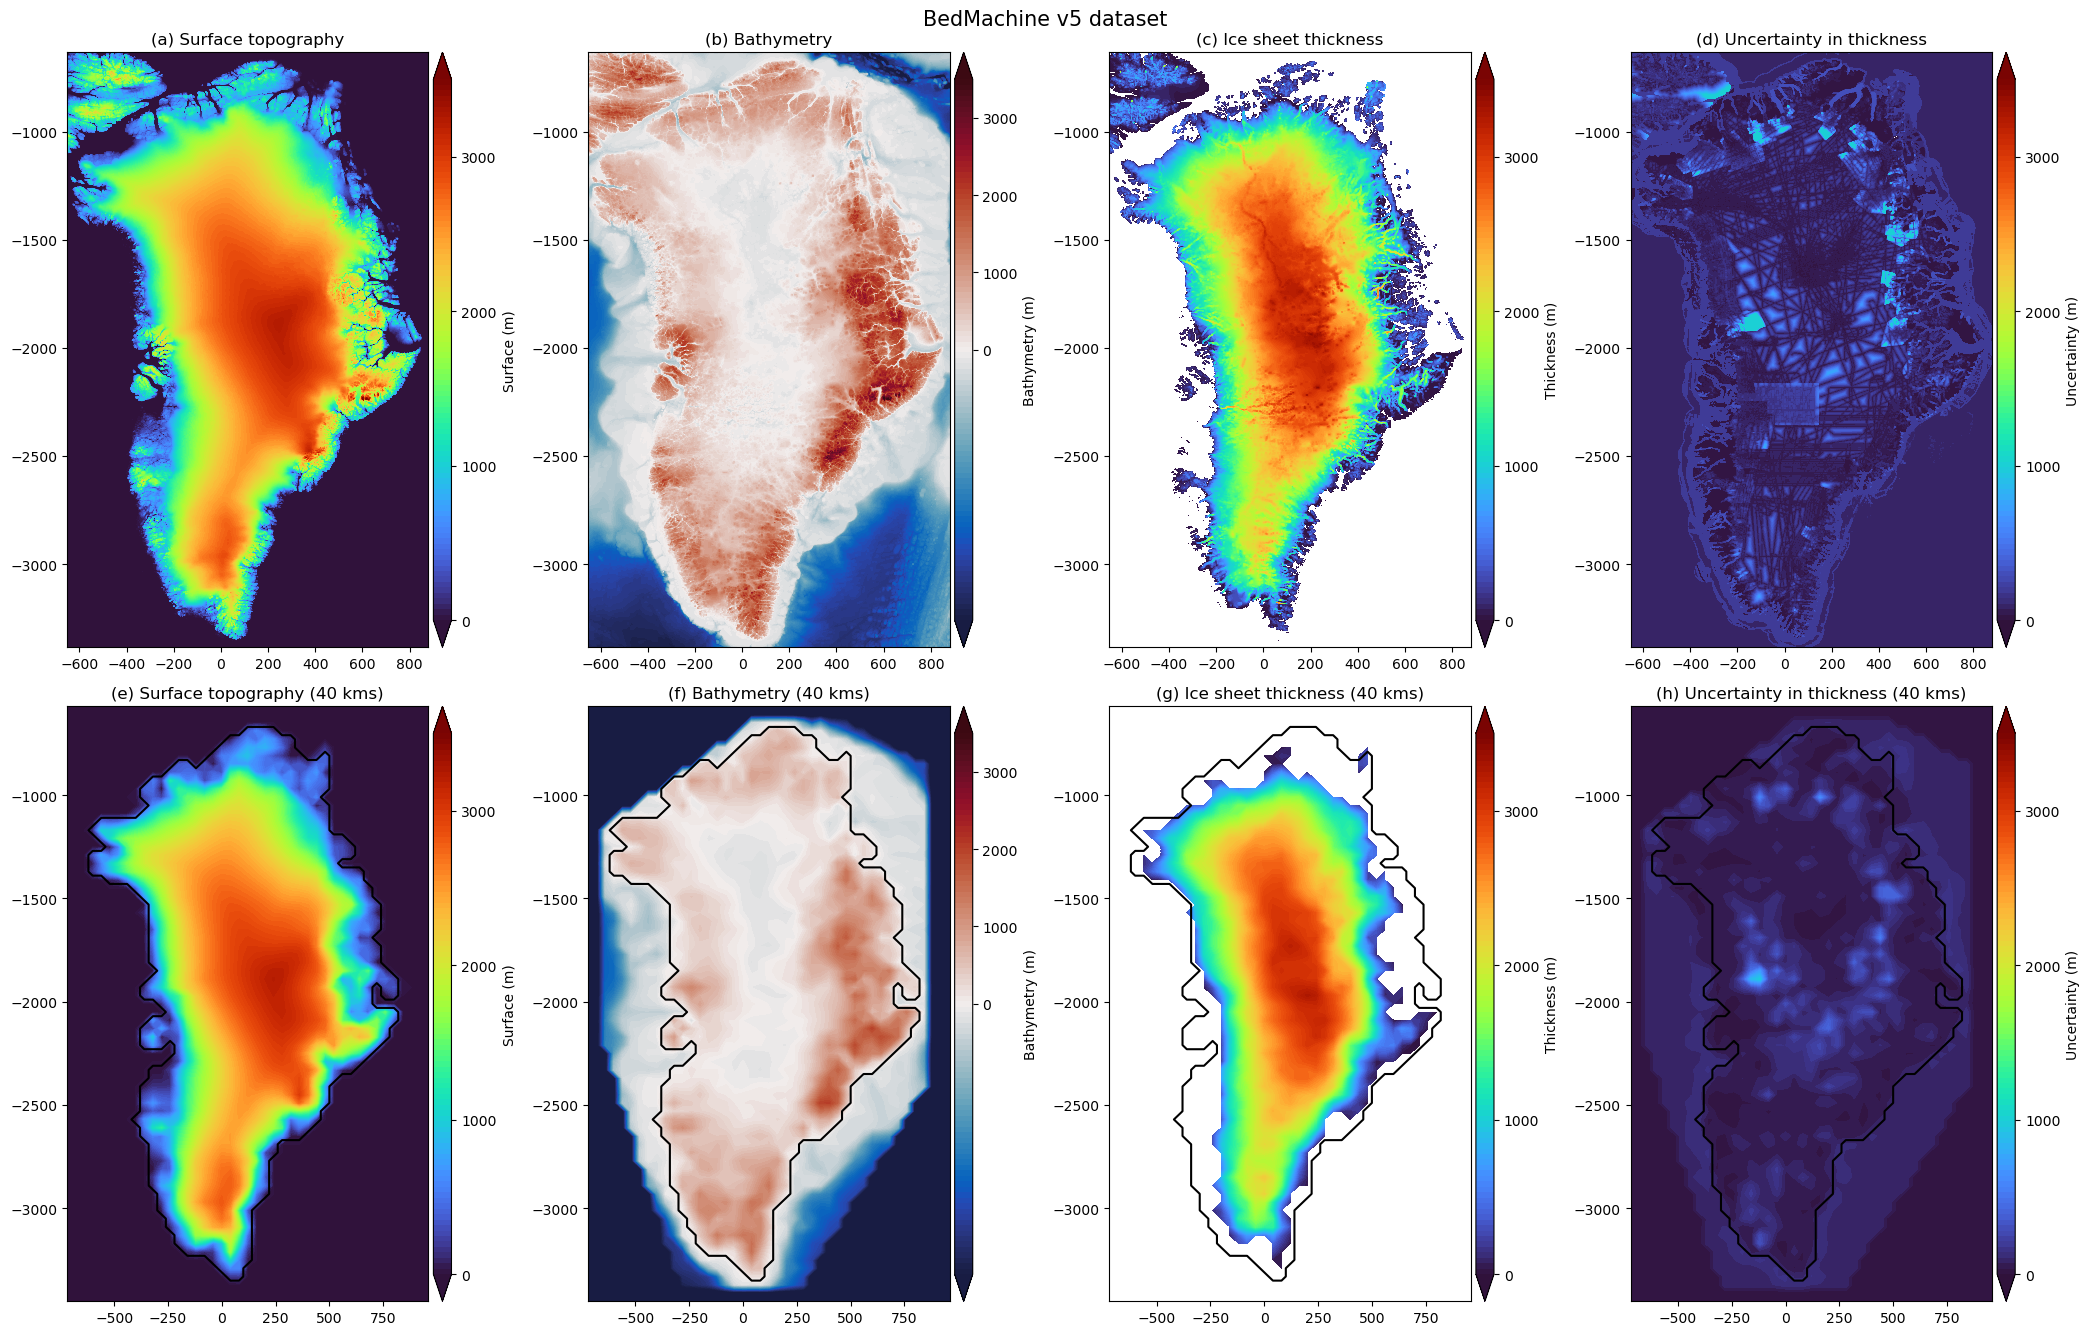

In [8]:
n_rows, n_cols = 2, 4
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.25)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_bm5['x'], 
                ds_bm5['y'], 
                zs_data_fullres,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Surface (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[0, 0].set_title("(a) Surface topography")

plot_normal_new(ds_bm5['x'], 
                ds_bm5['y'], 
                zl_data_fullres,
                cmap = cmo.balance, nbins = 100, vmin = -3500.0, vmax = 3500.0, center = 0.0,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Bathymetry (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[0, 1].set_title("(b) Bathymetry")

plot_normal_new(ds_bm5['x'], 
                ds_bm5['y'], 
                H_data_fullres_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Thickness (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[0, 2].set_title("(c) Ice sheet thickness")

plot_normal_new(ds_bm5['x'], 
                ds_bm5['y'], 
                H_uncert_data_fullres_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[0, 3],
                cbar_label = r"Uncertainty (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[0, 3].set_title("(d) Uncertainty in thickness")

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                ds_bm5_40kms['zs'].data,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Surface (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 0].set_title("(e) Surface topography (40 kms)")

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                ds_bm5_40kms['zl'].data,
                cmap = cmo.balance, nbins = 100, vmin = -3500.0, vmax = 3500.0, center = 0.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Bathymetry (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 1].set_title("(f) Bathymetry (40 kms)")

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                H_data_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Thickness (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 2].set_title("(g) Ice sheet thickness (40 kms)")

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                H_uncert_data_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[1, 3],
                cbar_label = r"Uncertainty (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1, 3].set_title("(h) Uncertainty in thickness (40 kms)")


plt.suptitle("BedMachine v5 dataset", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/BM5.png")

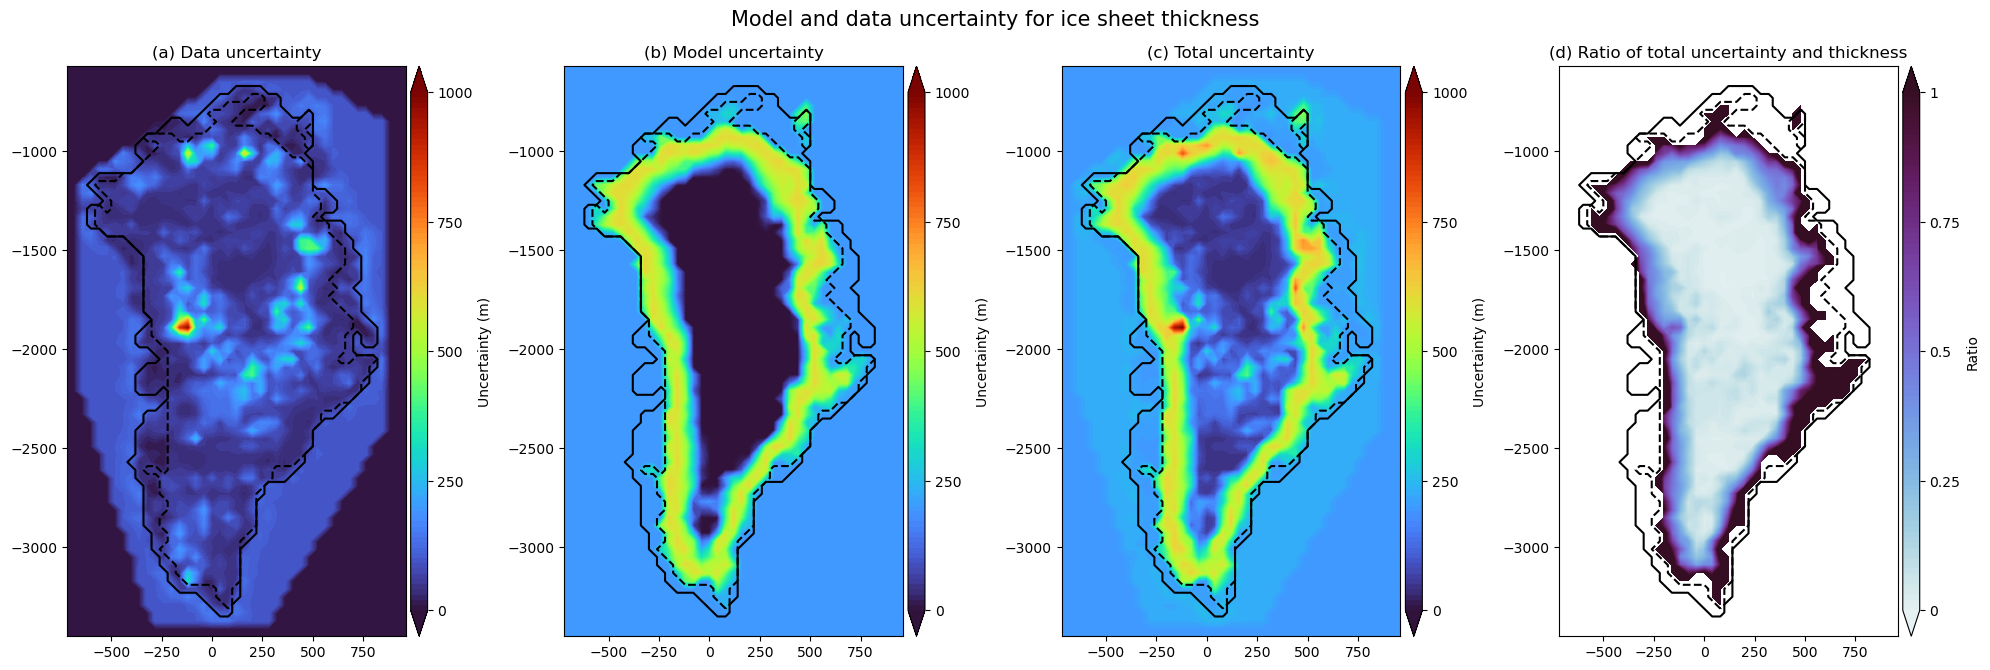

In [9]:
n_rows, n_cols = 1, 4
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                H_uncert_data_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1000.0, center = 500.0,
                fig = fig, ax = ax[0],
                cbar_label = r"Uncertainty (m)", cbar_ticks=[0.0, 250.0, 500.0, 750.0, 1000.0])

ax[0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0].set_title("(a) Data uncertainty")

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                H_uncert_model,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1000.0, center = 500.0,
                fig = fig, ax = ax[1],
                cbar_label = r"Uncertainty (m)", cbar_ticks=[0.0, 250.0, 500.0, 750.0, 1000.0])

ax[1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1].set_title("(b) Model uncertainty")

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                H_uncert_total_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1000.0, center = 500.0,
                fig = fig, ax = ax[2],
                cbar_label = r"Uncertainty (m)", cbar_ticks=[0.0, 250.0, 500.0, 750.0, 1000.0])

ax[2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[2].set_title("(c) Total uncertainty")

plot_normal_new(ds_bm5_40kms['x'], 
                ds_bm5_40kms['y'], 
                H_uncert_total_nan / H_data_nan,
                cmap = cmo.dense, nbins = 100, vmin = 0.0, vmax = 1.0, center = 0.5,
                fig = fig, ax = ax[3],
                cbar_label = r"Ratio", cbar_ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

ax[3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[3].set_title("(d) Ratio of total uncertainty and thickness")

plt.suptitle("Model and data uncertainty for ice sheet thickness", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/BM5_model_data_uncert.png")

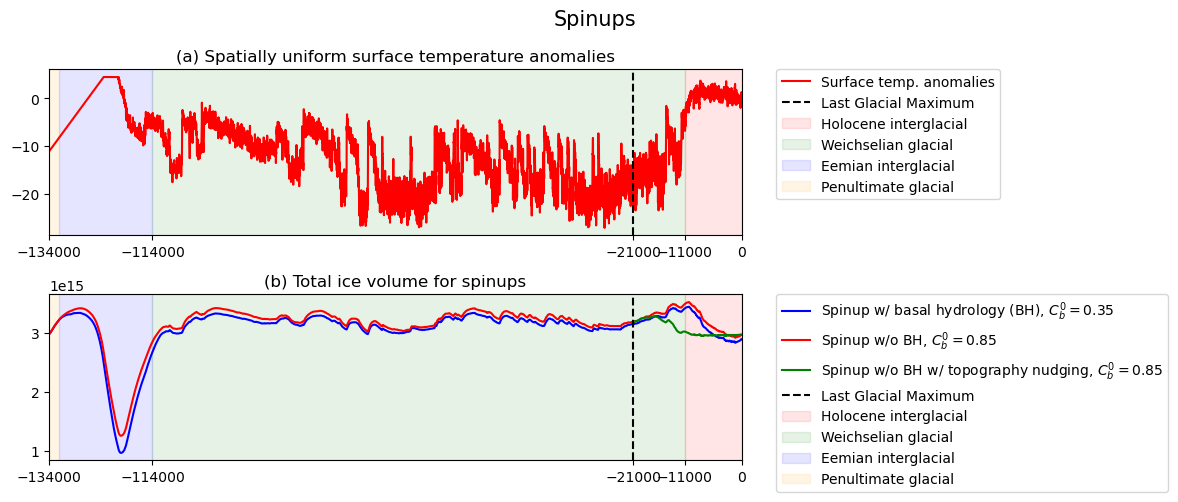

In [10]:
plt.rcParams["figure.figsize"] = (12, 5)
fig, ax = plt.subplots(2, 1)

ax[0].plot(ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['t'], 
           ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['delta_ts'], 
           color='red', linestyle='-', label="Surface temp. anomalies")

ax[0].axvline(x=-21000, color='k', linestyle='--', label = "Last Glacial Maximum")
ax[0].axvspan(xmin=-11000, xmax=0, color='red', alpha=0.1, label="Holocene interglacial")
ax[0].axvspan(xmin=-114000, xmax=-11000, color='green', alpha=0.1, label="Weichselian glacial")
ax[0].axvspan(xmin=-132000, xmax=-114000, color='blue', alpha=0.1, label="Eemian interglacial")
ax[0].axvspan(xmin=-134000, xmax=-132000, color='orange', alpha=0.1, label="Penultimate glacial")

ax[0].set_xticks([-134000, -114000, -21000, -11000, 0])
ax[0].set_xlim(-134000, 0)

# Add legend on the side
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[0].set_title("(a) Spatially uniform surface temperature anomalies")


ax[1].plot(ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['t'], 
           ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['V_tot'], 
           color='blue', linestyle='-', label="Spinup w/ basal hydrology (BH), $C_b^0 = 0.35$")
ax[1].plot(ds_ser_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['t'], 
           ds_ser_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['V_tot'], 
           color='red', linestyle='-', label="Spinup w/o BH, $C_b^0 = 0.85$")
ax[1].plot(ds_ser_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp['t'], 
           ds_ser_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp['V_tot'], 
           color='green', linestyle='-', label="Spinup w/o BH w/ topography nudging, $C_b^0 = 0.85$")

ax[1].axvline(x=-21000, color='k', linestyle='--', label = "Last Glacial Maximum")
ax[1].axvspan(xmin=-11000, xmax=0, color='red', alpha=0.1, label="Holocene interglacial")
ax[1].axvspan(xmin=-114000, xmax=-11000, color='green', alpha=0.1, label="Weichselian glacial")
ax[1].axvspan(xmin=-132000, xmax=-114000, color='blue', alpha=0.1, label="Eemian interglacial")
ax[1].axvspan(xmin=-134000, xmax=-132000, color='orange', alpha=0.1, label="Penultimate glacial")

ax[1].set_xticks([-134000, -114000, -21000, -11000, 0])
ax[1].set_xlim(-134000, 0)

# Add legend on the side
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[1].set_title("(b) Total ice volume for spinups")

plt.suptitle("Spinups", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/spinups.png")

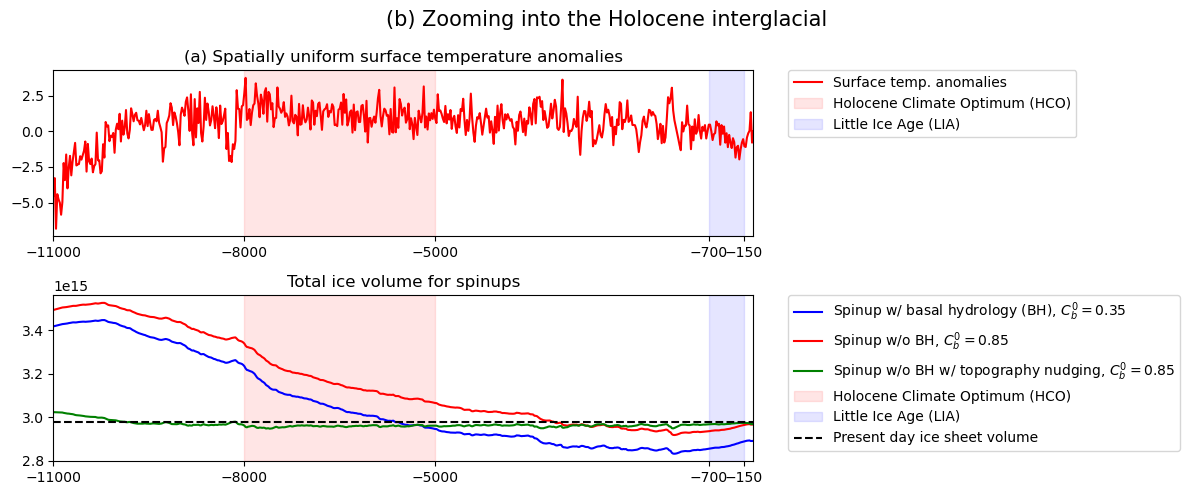

In [11]:
plt.rcParams["figure.figsize"] = (12, 5)
fig, ax = plt.subplots(2, 1)

ax[0].plot(ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['t'].data[6150:], 
           ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['delta_ts'].data[6150:], 
           color='red', linestyle='-', label="Surface temp. anomalies")

ax[0].axvspan(xmin=-8000, xmax=-5000, color='red', alpha=0.1, label="Holocene Climate Optimum (HCO)")
ax[0].axvspan(xmin=-700, xmax=-150, color='blue', alpha=0.1, label="Little Ice Age (LIA)")

ax[0].set_xticks([-11000, -8000, -5000, -700, -150])
ax[0].set_xlim(-11000, 0)

# Add legend on the side
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[0].set_title("(a) Spatially uniform surface temperature anomalies")

ax[1].plot(ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['t'].data[6150:], 
           ds_ser_grl40_bm5_paleo17a_CT4_3point5CS_spinup_0ka['V_tot'].data[6150:], 
           color='blue', linestyle='-', label="Spinup w/ basal hydrology (BH), $C_b^0 = 0.35$")
ax[1].plot(ds_ser_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['t'].data[6150:], 
           ds_ser_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['V_tot'].data[6150:], 
           color='red', linestyle='-', label="Spinup w/o BH, $C_b^0 = 0.85$")
ax[1].plot(ds_ser_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp['t'].data[500:], 
           ds_ser_grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp['V_tot'].data[500:], 
           color='green', linestyle='-', label="Spinup w/o BH w/ topography nudging, $C_b^0 = 0.85$")

ax[1].axvspan(xmin=-8000, xmax=-5000, color='red', alpha=0.1, label="Holocene Climate Optimum (HCO)")
ax[1].axvspan(xmin=-700, xmax=-150, color='blue', alpha=0.1, label="Little Ice Age (LIA)")
ax[1].axhline(y=ds_bm5_40kms["V_dummy2d"].data[0, 0], color='k', linestyle='--', label = "Present day ice sheet volume")

ax[1].set_xticks([-11000, -8000, -5000, -700, -150])
ax[1].set_xlim(-11000, 0)

# Add legend on the side
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[1].set_title("Total ice volume for spinups")

plt.suptitle("(b) Zooming into the Holocene interglacial", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/spinups_holocene.png")

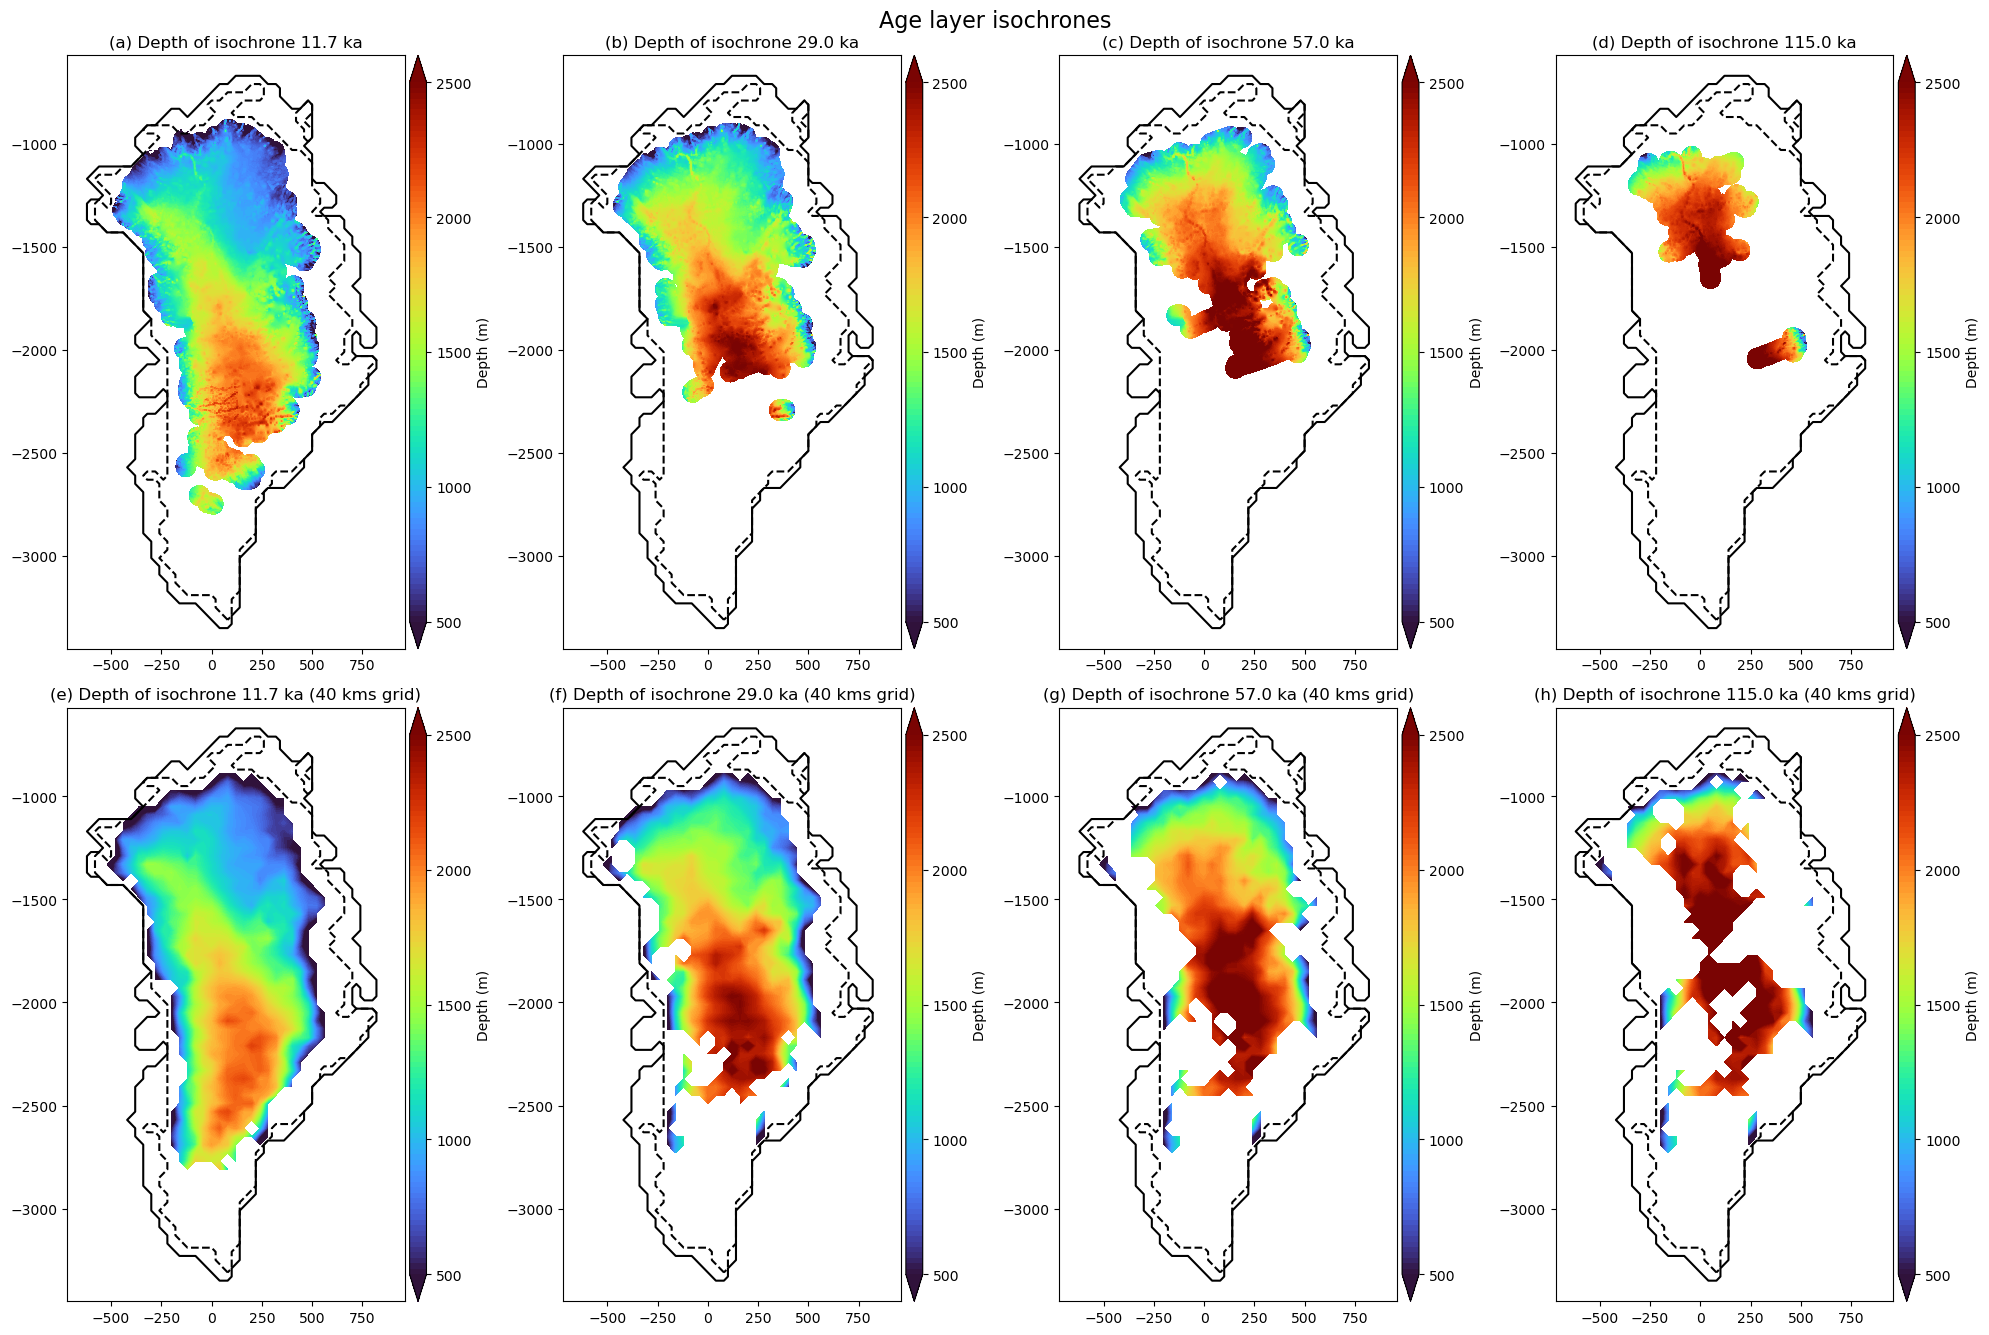

In [12]:
n_rows, n_cols = 2, 4
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

age_isochrones = ds_age['age_iso'].data

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['depth_iso'][0],
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 0].set_title(f"(a) Depth of isochrone {age_isochrones[0]/1000} ka")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['depth_iso'][1],
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 1].set_title(f"(b) Depth of isochrone {age_isochrones[1]/1000} ka")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['depth_iso'][2],
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 2].set_title(f"(c) Depth of isochrone {age_isochrones[2]/1000} ka")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['depth_iso'][3],
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[0, 3],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 3].set_title(f"(d) Depth of isochrone {age_isochrones[3]/1000} ka")

# plot_normal_new(ds_age['x'], 
#                 ds_age['y'], 
#                 ds_age['depth_iso_uncert'][0],
#                 cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 500.0, center = 250.0,
#                 fig = fig, ax = ax[1, 0],
#                 cbar_label = r"Depth (m)", cbar_ticks=[0.0, 250.0, 500.0])

# ax[1, 0].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[1, 0].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[1, 0].set_title(f"(e) Depth uncertainty of isochrone {age_isochrones[0]/1000} ka")

# plot_normal_new(ds_age['x'], 
#                 ds_age['y'], 
#                 ds_age['depth_iso_uncert'][1],
#                 cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 500.0, center = 250.0,
#                 fig = fig, ax = ax[1, 1],
#                 cbar_label = r"Depth (m)", cbar_ticks=[0.0, 250.0, 500.0])

# ax[1, 1].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[1, 1].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[1, 1].set_title(f"(f) Depth uncertainty of isochrone {age_isochrones[1]/1000} ka")

# plot_normal_new(ds_age['x'], 
#                 ds_age['y'], 
#                 ds_age['depth_iso_uncert'][2],
#                 cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 500.0, center = 250.0,
#                 fig = fig, ax = ax[1, 2],
#                 cbar_label = r"Depth (m)", cbar_ticks=[0.0, 250.0, 500.0])

# ax[1, 2].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[1, 2].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[1, 2].set_title(f"(g) Depth uncertainty of isochrone {age_isochrones[2]/1000} ka")

# plot_normal_new(ds_age['x'], 
#                 ds_age['y'], 
#                 ds_age['depth_iso_uncert'][3],
#                 cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 500.0, center = 250.0,
#                 fig = fig, ax = ax[1, 3],
#                 cbar_label = r"Depth (m)", cbar_ticks=[0.0, 250.0, 500.0])

# ax[1, 3].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[1, 3].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[1, 3].set_title(f"(h) Depth uncertainty of isochrone {age_isochrones[3]/1000} ka")

age_isochrones = ds_age['age_iso'].data

field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
                                                               ds_age_40kms['H'].data, 
                                                               ds_age_40kms['age_c'].data, 
                                                               age_iso_value = ds_age['age_iso'].data[0])
field[field == 0.0] = np.nan
field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                field,
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 0].set_title(f"(e) Depth of isochrone {age_isochrones[0]/1000} ka (40 kms grid)")


field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
                                                               ds_age_40kms['H'].data, 
                                                               ds_age_40kms['age_c'].data, 
                                                               age_iso_value = ds_age['age_iso'].data[1])
field[field == 0.0] = np.nan
field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                field,
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 1].set_title(f"(f) Depth of isochrone {age_isochrones[1]/1000} ka (40 kms grid)")

field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
                                                               ds_age_40kms['H'].data, 
                                                               ds_age_40kms['age_c'].data, 
                                                               age_iso_value = ds_age['age_iso'].data[2])
field[field == 0.0] = np.nan
field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                field,
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 2].set_title(f"(g) Depth of isochrone {age_isochrones[2]/1000} ka (40 kms grid)")

field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
                                                               ds_age_40kms['H'].data, 
                                                               ds_age_40kms['age_c'].data, 
                                                               age_iso_value = ds_age['age_iso'].data[3])
field[field == 0.0] = np.nan
field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                field,
                cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
                fig = fig, ax = ax[1, 3],
                cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 3].set_title(f"(h) Depth of isochrone {age_isochrones[3]/1000} ka (40 kms grid)")

fig.suptitle('Age layer isochrones', fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/age_isochrones_data.png")

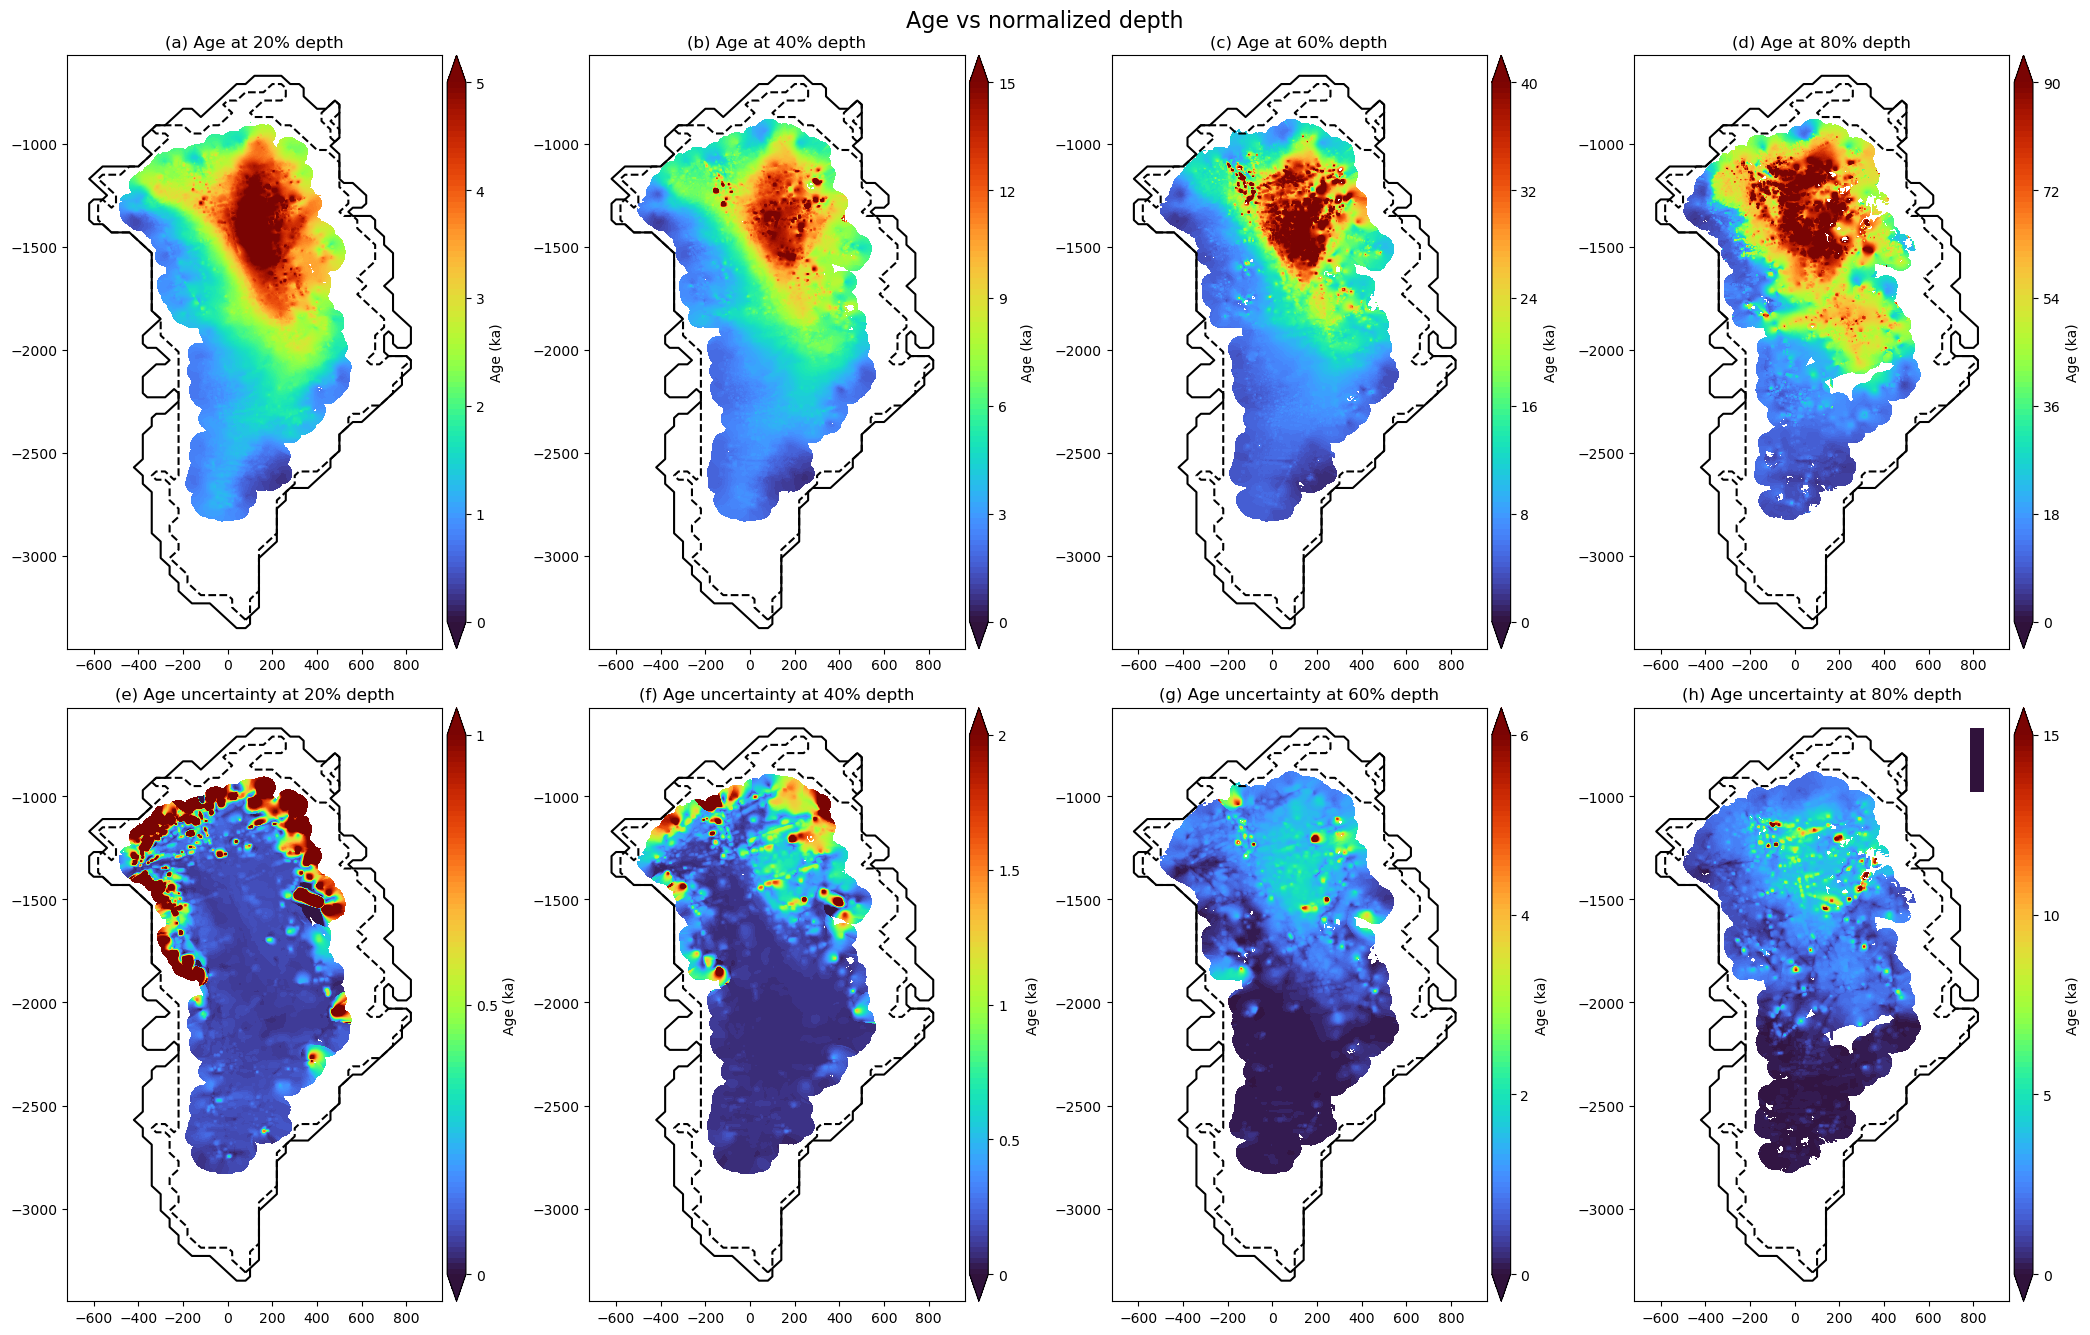

In [13]:
n_rows, n_cols = 2, 4
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.25)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

age_isochrones = ds_age['age_iso'].data

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm'][4] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 5.0, center = 2.5,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 0].set_title(f"(a) Age at 20% depth")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm'][9] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 15.0, center = 7.5,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 3.0, 6.0, 9.0, 12.0, 15.0])

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 1].set_title(f"(b) Age at 40% depth")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm'][14] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 40.0, center = 20.0,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 8.0, 16.0, 24.0, 32.0, 40.0])

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 2].set_title(f"(c) Age at 60% depth")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm'][19] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 90.0, center = 45.0,
                fig = fig, ax = ax[0, 3],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 18.0, 36.0, 54.0, 72.0, 90.0])

ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 3].set_title(f"(d) Age at 80% depth")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm_uncert'][4] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1.0, center = 0.5,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 0.5, 1.0])

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 0].set_title(f"(e) Age uncertainty at 20% depth")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm_uncert'][9] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 2.0, center = 1.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 0.5, 1.0, 1.5, 2.0])

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 1].set_title(f"(f) Age uncertainty at 40% depth")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm_uncert'][14] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 6.0, center = 3.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0])

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 2].set_title(f"(g) Age uncertainty at 60% depth")

plot_normal_new(ds_age['x'], 
                ds_age['y'], 
                ds_age['age_norm_uncert'][19] / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 15.0, center = 7.5,
                fig = fig, ax = ax[1, 3],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 5.0, 10.0, 15.0])

ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 3].set_title(f"(h) Age uncertainty at 80% depth")

fig.suptitle('Age vs normalized depth', fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/age_normalized_depth_data.png")

In [14]:
# n_rows, n_cols = 1, 4
# aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
# subplot_width = 4
# subplot_height = subplot_width / aspect_ratio

# plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
# fig, ax = plt.subplots(n_rows, n_cols)

# age_isochrones = ds_age['age_iso'].data

# field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
#                                                                ds_age_40kms['H'].data, 
#                                                                ds_age_40kms['age_c'].data, 
#                                                                age_iso_value = ds_age['age_iso'].data[0])
# field[field == 0.0] = np.nan
# field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

# plot_normal_new(ds_age_40kms['x'], 
#                 ds_age_40kms['y'], 
#                 field,
#                 cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
#                 fig = fig, ax = ax[0],
#                 cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

# ax[0].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[0].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[0].set_title(f"(a) Depth of isochrone {age_isochrones[0]/1000} ka")


# field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
#                                                                ds_age_40kms['H'].data, 
#                                                                ds_age_40kms['age_c'].data, 
#                                                                age_iso_value = ds_age['age_iso'].data[1])
# field[field == 0.0] = np.nan
# field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

# plot_normal_new(ds_age_40kms['x'], 
#                 ds_age_40kms['y'], 
#                 field,
#                 cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
#                 fig = fig, ax = ax[1],
#                 cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

# ax[1].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[1].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[1].set_title(f"(a) Depth of isochrone {age_isochrones[1]/1000} ka")

# field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
#                                                                ds_age_40kms['H'].data, 
#                                                                ds_age_40kms['age_c'].data, 
#                                                                age_iso_value = ds_age['age_iso'].data[2])
# field[field == 0.0] = np.nan
# field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

# plot_normal_new(ds_age_40kms['x'], 
#                 ds_age_40kms['y'], 
#                 field,
#                 cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
#                 fig = fig, ax = ax[2],
#                 cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

# ax[2].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[2].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[2].set_title(f"(a) Depth of isochrone {age_isochrones[2]/1000} ka")

# field = ds_age_40kms['H'].data - ageContours.get_age_isochrone(ds_age_40kms['sigma'].data, 
#                                                                ds_age_40kms['H'].data, 
#                                                                ds_age_40kms['age_c'].data, 
#                                                                age_iso_value = ds_age['age_iso'].data[3])
# field[field == 0.0] = np.nan
# field[ds_age_40kms['age_c'][-2] == 1000000.0] = np.nan

# plot_normal_new(ds_age_40kms['x'], 
#                 ds_age_40kms['y'], 
#                 field,
#                 cmap = "turbo", nbins = 100, vmin = 500.0, vmax = 2500.0, center = 1500.0,
#                 fig = fig, ax = ax[3],
#                 cbar_label = r"Depth (m)", cbar_ticks=[500.0, 1000.0, 1500.0, 2000.0, 2500.0])

# ax[3].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[3].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# ax[3].set_title(f"(a) Depth of isochrone {age_isochrones[3]/1000} ka")


# fig.suptitle('Age layer isochrones interpolated and downsampled to 40 kms', fontsize = 16)
# plt.tight_layout()

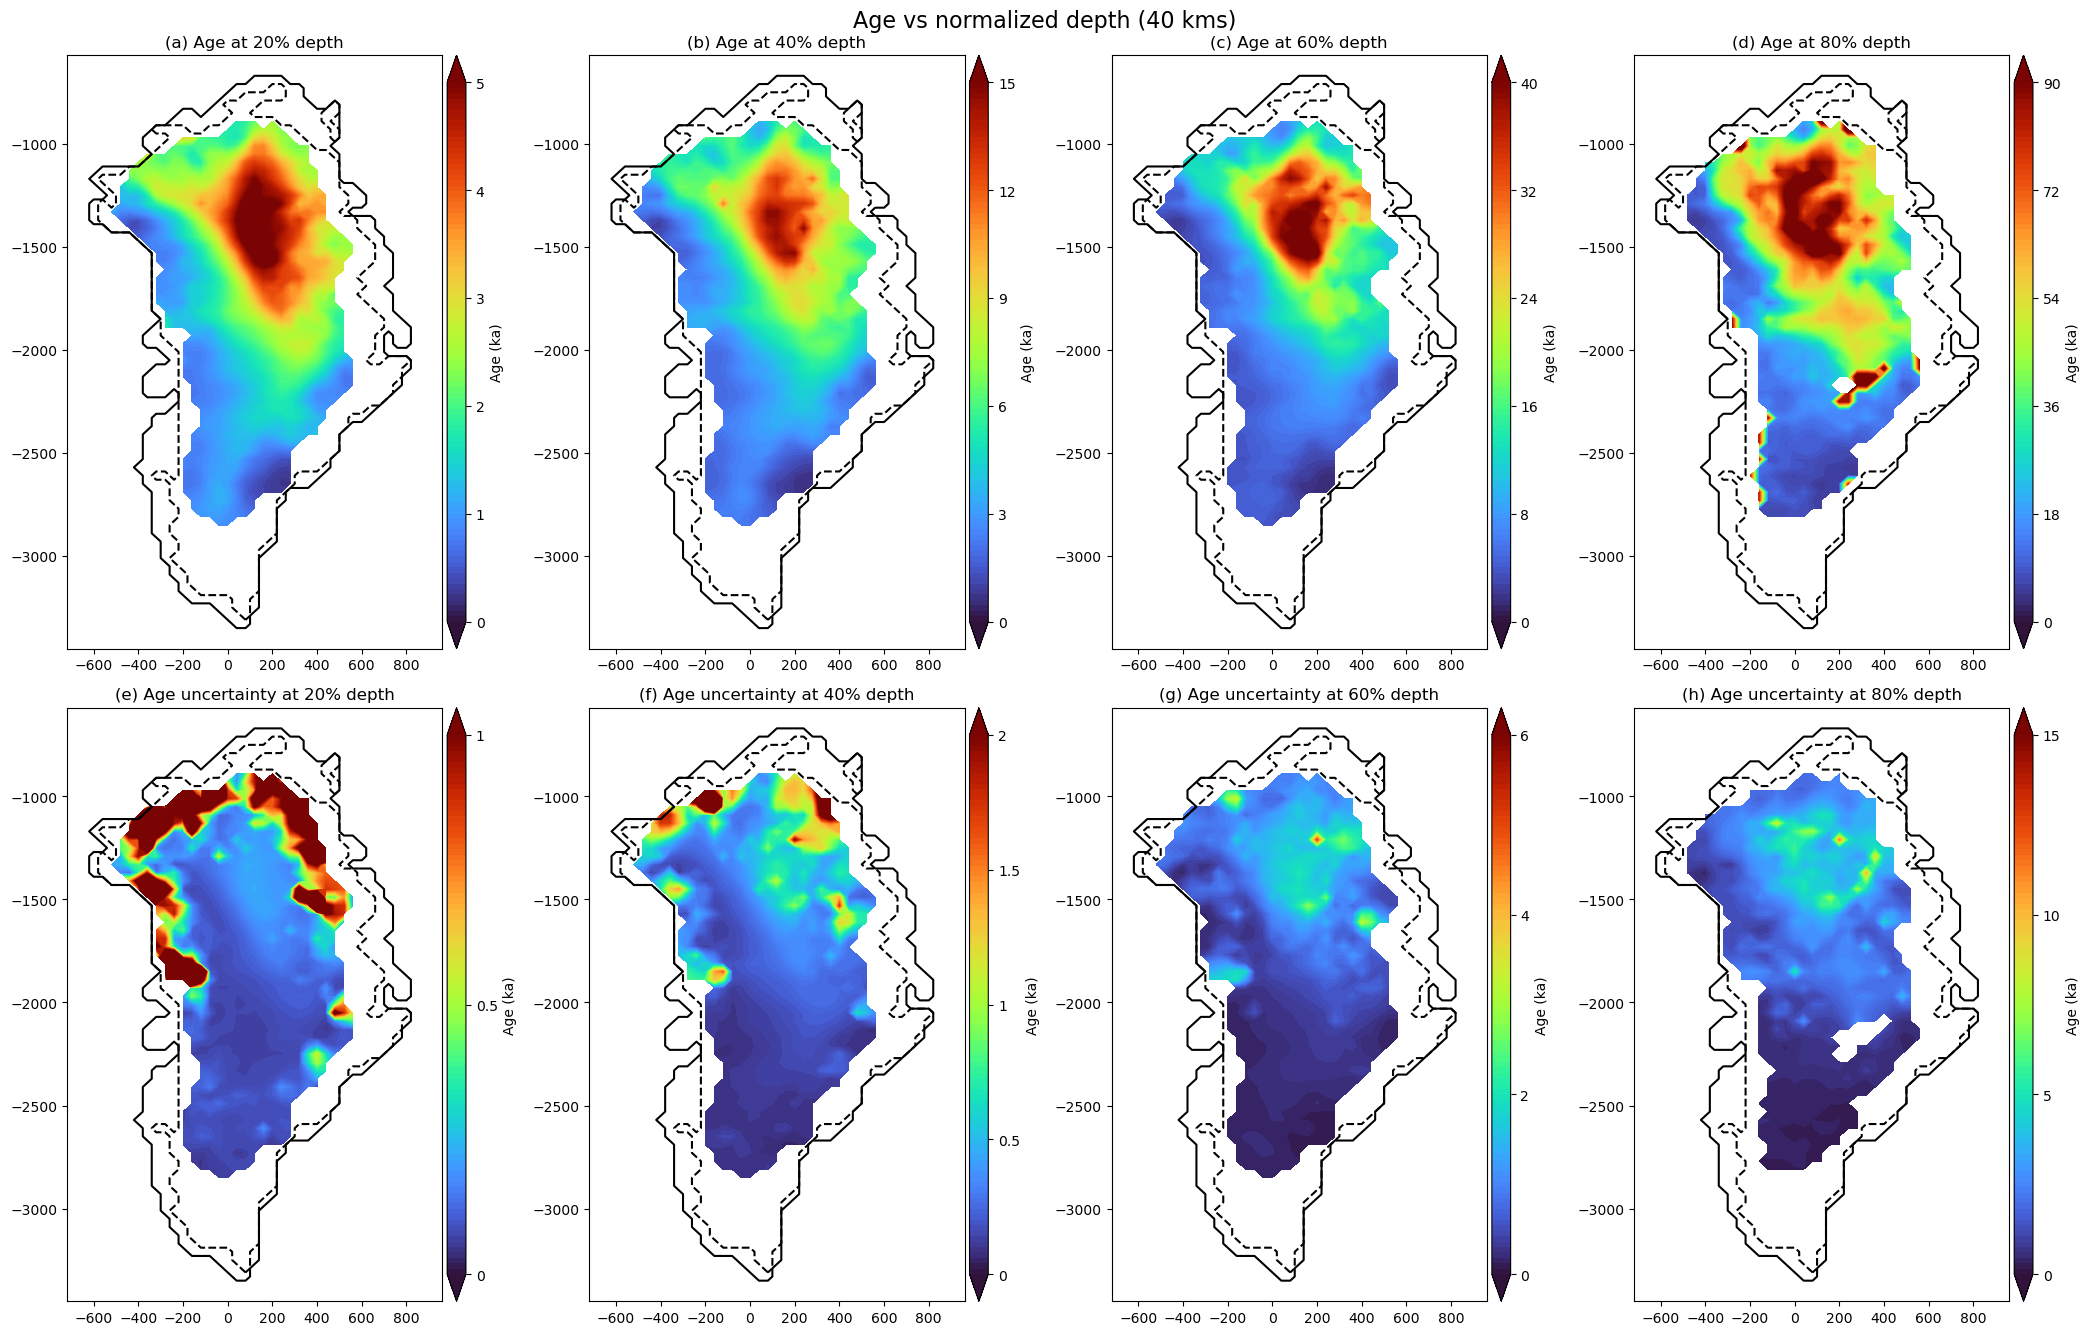

In [15]:
n_rows, n_cols = 2, 4
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.25)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

ds_age_40kms['age_c'].data[ds_age_40kms['age_c'].data < 0.0] = np.nan
ds_age_40kms['age_c_uncert_unbounded'].data[ds_age_40kms['age_c_uncert_unbounded'].data < 0.0] = np.nan

slice2d = slice_at_depth_linear(ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.8, return_weights=False)
slice2d[slice2d >= 900000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 5.0, center = 2.5,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 0].set_title(f"(a) Age at 20% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d >= 900000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 15.0, center = 7.5,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 3.0, 6.0, 9.0, 12.0, 15.0])

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 1].set_title(f"(b) Age at 40% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.4, return_weights=False)
slice2d[slice2d >= 900000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 40.0, center = 20.0,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 8.0, 16.0, 24.0, 32.0, 40.0])

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 2].set_title(f"(c) Age at 60% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d >= 900000.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 90.0, center = 45.0,
                fig = fig, ax = ax[0, 3],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 18.0, 36.0, 54.0, 72.0, 90.0])

ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[0, 3].set_title(f"(d) Age at 80% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.8, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1.0, center = 0.5,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 0.5, 1.0])

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 0].set_title(f"(e) Age uncertainty at 20% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 2.0, center = 1.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 0.5, 1.0, 1.5, 2.0])

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 1].set_title(f"(f) Age uncertainty at 40% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.4, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 6.0, center = 3.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0])

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 2].set_title(f"(g) Age uncertainty at 60% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 15.0, center = 7.5,
                fig = fig, ax = ax[1, 3],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 5.0, 10.0, 15.0])

ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

ax[1, 3].set_title(f"(h) Age uncertainty at 80% depth")

fig.suptitle('Age vs normalized depth (40 kms)', fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/age_normalized_depth_data_40kms.png")

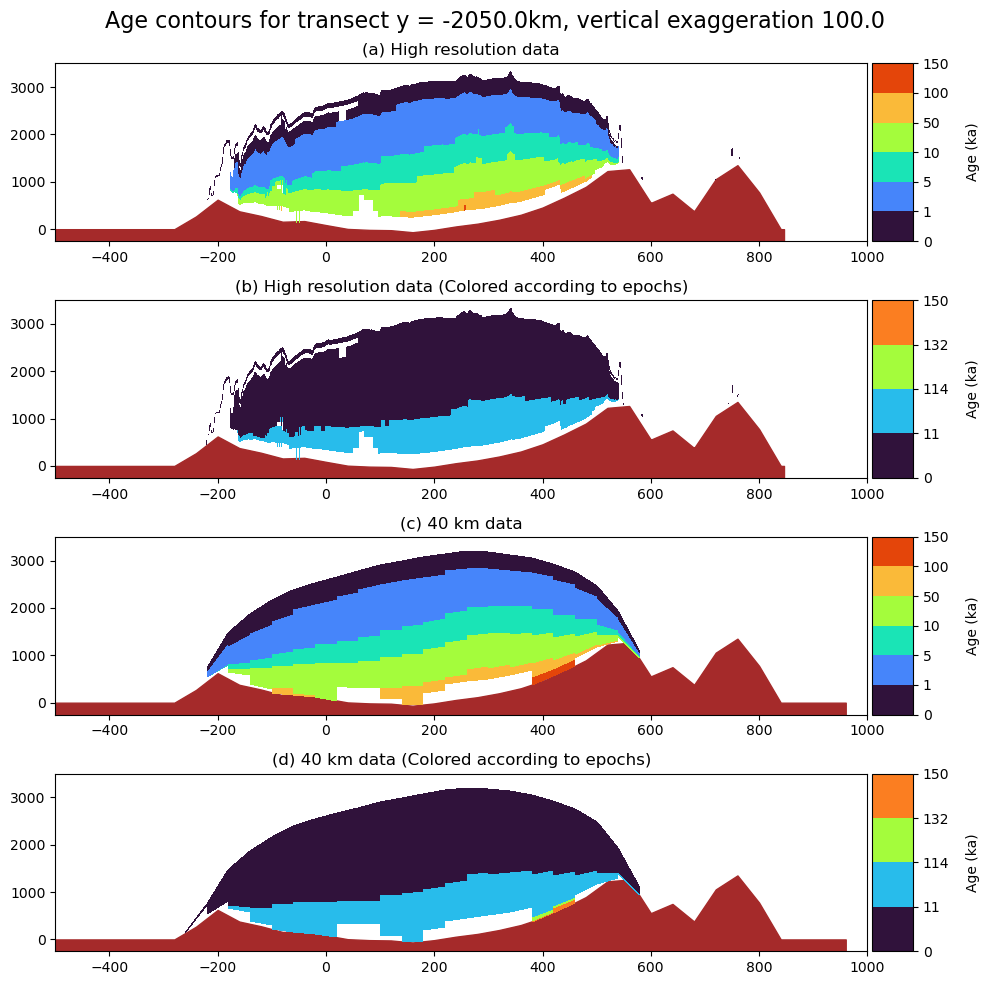

In [16]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(4, 1)

x_parallel_transect_idx = 35 # Corresponds to y = -2050 km
x_parallel_transect_raw_data_idx = 1294 # Corresponds to y = -2050 km
x = ds_surfvel_data_40km['x'].data.copy()
y = ds_surfvel_data_40km['y'].data.copy()

zb = ds_bm5_40kms['zb'].data.copy()
H = ds_age_40kms['H'].data.copy()
age_c = ds_age_40kms['age_c'].data
age_c[age_c < 0.0] = np.nan
age_c[age_c > 500000.0] = np.nan
sigma_level_c = ds_age_40kms['sigma'].data.copy()

x_raw_data = ds_age_correct['xData'].data
y_raw_data = ds_age_correct['yData'].data
sigma_level_c_raw_data = np.arange(0., 1.+1/25.0, 1/25.0)
H_raw_data = ds_age_correct['H'].data

xMesh = np.tile(x[:, np.newaxis], sigma_level_c.shape[0]).T
yMesh = np.tile(y[:, np.newaxis], sigma_level_c.shape[0]).T
xMesh_raw_data = np.tile(x_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T
yMesh_raw_data = np.tile(y_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T

levels = [0.0, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

interp_func = interp1d(x, zb[x_parallel_transect_idx, :], kind='linear')
zb_interpolated = interp_func(x_raw_data)
z_coords = zb_interpolated + sigma_level_c_raw_data[:, np.newaxis]*H_raw_data[x_parallel_transect_raw_data_idx, :]

ax[0].fill_between(x_raw_data, zb_interpolated, -250.0, color='brown', alpha=1.0)
im = ax[0].pcolormesh(xMesh_raw_data, z_coords, ds_age_correct['age_c'][:, x_parallel_transect_raw_data_idx, :]/1000, cmap = cmap_disc, norm = norm)
ax[0].set_xlim(-500, 1000)
ax[0].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[0].set_title("(a) High resolution data")

levels = [0.0, 11.0, 114.0, 132.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[1].fill_between(x_raw_data, zb_interpolated, -250.0, color='brown', alpha=1.0)
im = ax[1].pcolormesh(xMesh_raw_data, z_coords, ds_age_correct['age_c'][:, x_parallel_transect_raw_data_idx, :]/1000, cmap = cmap_disc, norm = norm)
ax[1].set_xlim(-500, 1000)
ax[1].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[1].set_title("(b) High resolution data (Colored according to epochs)")

levels = [0.0, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[2].fill_between(x, zb[x_parallel_transect_idx, :], -250.0, color='brown', alpha=1.0)
z_coords = zb[x_parallel_transect_idx, :] + sigma_level_c[:, np.newaxis]*H[x_parallel_transect_idx, :]
im = ax[2].pcolormesh(xMesh, z_coords, age_c[:, x_parallel_transect_idx, :]/1000, cmap = cmap_disc, norm = norm)
ax[2].set_xlim(-500, 1000)
ax[2].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[2].set_title("(c) 40 km data")

levels = [0.0, 11.0, 114.0, 132.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[3].fill_between(x, zb[x_parallel_transect_idx, :], -250.0, color='brown', alpha=1.0)
z_coords = zb[x_parallel_transect_idx, :] + sigma_level_c[:, np.newaxis]*H[x_parallel_transect_idx, :]
im = ax[3].pcolormesh(xMesh, z_coords, age_c[:, x_parallel_transect_idx, :]/1000, cmap = cmap_disc, norm = norm)
ax[3].set_xlim(-500, 1000)
ax[3].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[3].set_title("(d) 40 km data (Colored according to epochs)")

fig.suptitle(f"Age contours for transect y = {y_raw_data[x_parallel_transect_raw_data_idx]}km, vertical exaggeration 100.0", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/transect_y_minus_2050.png")

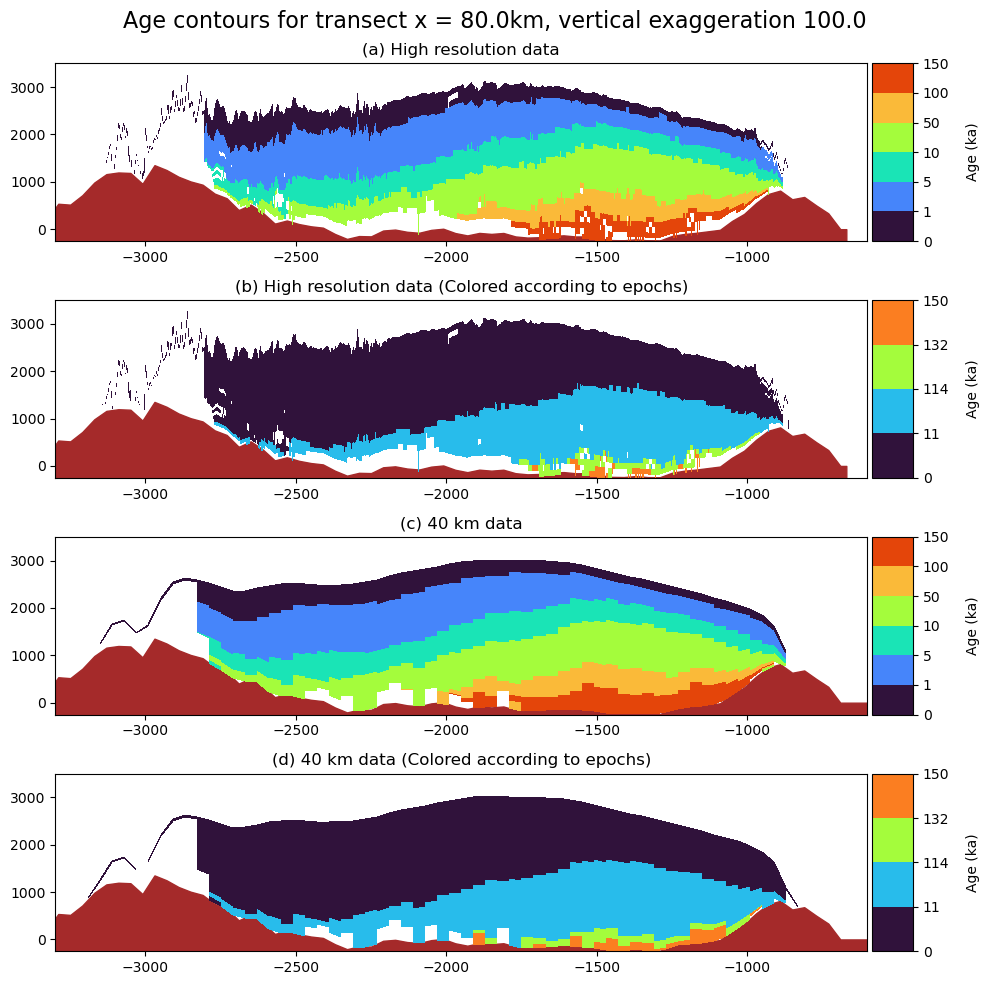

In [17]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(4, 1)

y_parallel_transect_idx = 20 # Corresponds to x = 80 km
y_parallel_transect_raw_data_idx = 712 # Corresponds to x = 80 km

x = ds_surfvel_data_40km['x'].data.copy()
y = ds_surfvel_data_40km['y'].data.copy()

zb = ds_bm5_40kms['zb'].data.copy()
H = ds_age_40kms['H'].data.copy()
age_c = ds_age_40kms['age_c'].data
age_c[age_c < 0.0] = np.nan
age_c[age_c > 500000.0] = np.nan
sigma_level_c = ds_age_40kms['sigma'].data.copy()

x_raw_data = ds_age_correct['xData'].data
y_raw_data = ds_age_correct['yData'].data
sigma_level_c_raw_data = np.arange(0., 1.+1/25.0, 1/25.0)
H_raw_data = ds_age_correct['H'].data

xMesh = np.tile(x[:, np.newaxis], sigma_level_c.shape[0]).T
yMesh = np.tile(y[:, np.newaxis], sigma_level_c.shape[0]).T
xMesh_raw_data = np.tile(x_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T
yMesh_raw_data = np.tile(y_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T

levels = [0.0, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

interp_func = interp1d(y, zb[:, y_parallel_transect_idx], kind='linear')
zb_interpolated = interp_func(y_raw_data)
z_coords = zb_interpolated + sigma_level_c_raw_data[:, np.newaxis]*H_raw_data[:, y_parallel_transect_raw_data_idx]

ax[0].fill_between(y_raw_data, zb_interpolated, -250, color='brown', alpha=1.0)
im = ax[0].pcolormesh(yMesh_raw_data, z_coords, ds_age_correct['age_c'][:, :, y_parallel_transect_raw_data_idx]/1000.0, cmap = cmap_disc, norm = norm)
ax[0].set_xlim(-3300, -600)
ax[0].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[0].set_title("(a) High resolution data")

levels = [0.0, 11.0, 114.0, 132.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[1].fill_between(y_raw_data, zb_interpolated, -250, color='brown', alpha=1.0)
im = ax[1].pcolormesh(yMesh_raw_data, z_coords, ds_age_correct['age_c'][:, :, y_parallel_transect_raw_data_idx]/1000.0, cmap = cmap_disc, norm = norm)
ax[1].set_xlim(-3300, -600)
ax[1].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[1].set_title("(b) High resolution data (Colored according to epochs)")

levels = [0.0, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[2].fill_between(y, zb[:, y_parallel_transect_idx], -250, color='brown', alpha=1.0)
z_coords = zb[:, y_parallel_transect_idx] + sigma_level_c[:, np.newaxis]*H[:, y_parallel_transect_idx]
im = ax[2].pcolormesh(yMesh, z_coords, age_c[:, :, y_parallel_transect_idx]/1000.0, cmap = cmap_disc, norm = norm)
ax[2].set_xlim(-3300, -600)
ax[2].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[2].set_title("(c) 40 km data")

levels = [0.0, 11.0, 114.0, 132.0, 150.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[3].fill_between(y, zb[:, y_parallel_transect_idx], -250.0, color='brown', alpha=1.0)
z_coords = zb[:, y_parallel_transect_idx] + sigma_level_c[:, np.newaxis]*H[:, y_parallel_transect_idx]
im = ax[3].pcolormesh(yMesh, z_coords, age_c[:, :, y_parallel_transect_idx]/1000.0, cmap = cmap_disc, norm = norm)
ax[3].set_xlim(-3300, -600)
ax[3].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[3].set_title("(d) 40 km data (Colored according to epochs)")

fig.suptitle(f"Age contours for transect x = {x_raw_data[y_parallel_transect_raw_data_idx]}km, vertical exaggeration 100.0", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/transect_x_80.png")

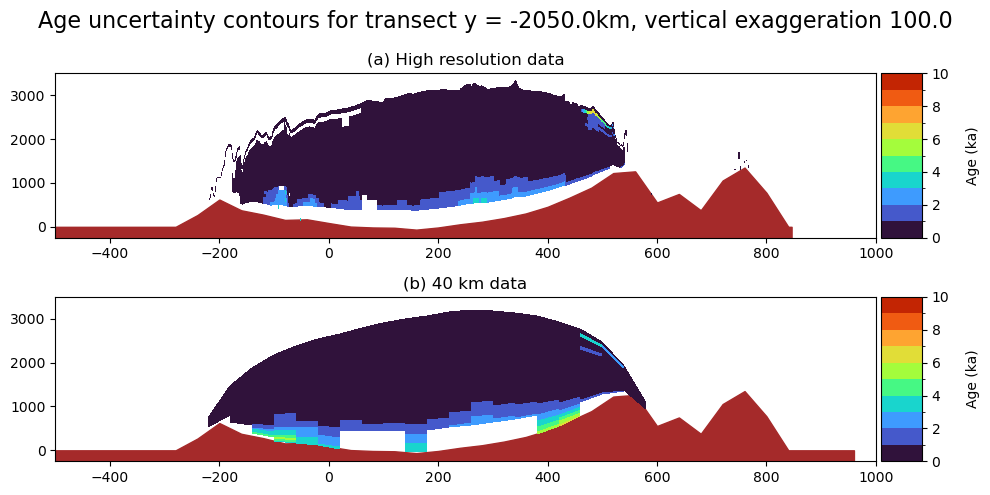

In [18]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(2, 1)

x_parallel_transect_idx = 35 # Corresponds to y = -2050 km
x_parallel_transect_raw_data_idx = 1294 # Corresponds to y = -2050 km
x = ds_surfvel_data_40km['x'].data.copy()
y = ds_surfvel_data_40km['y'].data.copy()

zb = ds_bm5_40kms['zb'].data.copy()
H = ds_age_40kms['H'].data.copy()
age_c = ds_age_40kms['age_c'].data
age_c[age_c < 0.0] = np.nan
age_c_uncert = ds_age_40kms['age_c_uncert_unbounded'].data
age_c_uncert[age_c_uncert < 0.0] = np.nan
sigma_level_c = ds_age_40kms['sigma'].data.copy()

x_raw_data = ds_age_correct['xData'].data
y_raw_data = ds_age_correct['yData'].data
sigma_level_c_raw_data = np.arange(0., 1.+1/25.0, 1/25.0)
H_raw_data = ds_age_correct['H'].data

xMesh = np.tile(x[:, np.newaxis], sigma_level_c.shape[0]).T
yMesh = np.tile(y[:, np.newaxis], sigma_level_c.shape[0]).T
xMesh_raw_data = np.tile(x_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T
yMesh_raw_data = np.tile(y_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T

levels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

interp_func = interp1d(x, zb[x_parallel_transect_idx, :], kind='linear')
zb_interpolated = interp_func(x_raw_data)
z_coords = zb_interpolated + sigma_level_c_raw_data[:, np.newaxis]*H_raw_data[x_parallel_transect_raw_data_idx, :]

ax[0].fill_between(x_raw_data, zb_interpolated, -250.0, color='brown', alpha=1.0)
im = ax[0].pcolormesh(xMesh_raw_data, z_coords, ds_age_correct['age_c_uncert'][:, x_parallel_transect_raw_data_idx, :]/1000, cmap = cmap_disc, norm = norm)
ax[0].set_xlim(-500, 1000)
ax[0].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[0].set_title("(a) High resolution data")

levels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[1].fill_between(x, zb[x_parallel_transect_idx, :], -250.0, color='brown', alpha=1.0)
z_coords = zb[x_parallel_transect_idx, :] + sigma_level_c[:, np.newaxis]*H[x_parallel_transect_idx, :]
im = ax[1].pcolormesh(xMesh, z_coords, age_c_uncert[:, x_parallel_transect_idx, :]/1000, cmap = cmap_disc, norm = norm)
ax[1].set_xlim(-500, 1000)
ax[1].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[1].set_title("(b) 40 km data")

fig.suptitle(f"Age uncertainty contours for transect y = {y_raw_data[x_parallel_transect_raw_data_idx]}km, vertical exaggeration 100.0", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/transect_y_minus_2050_uncert.png")

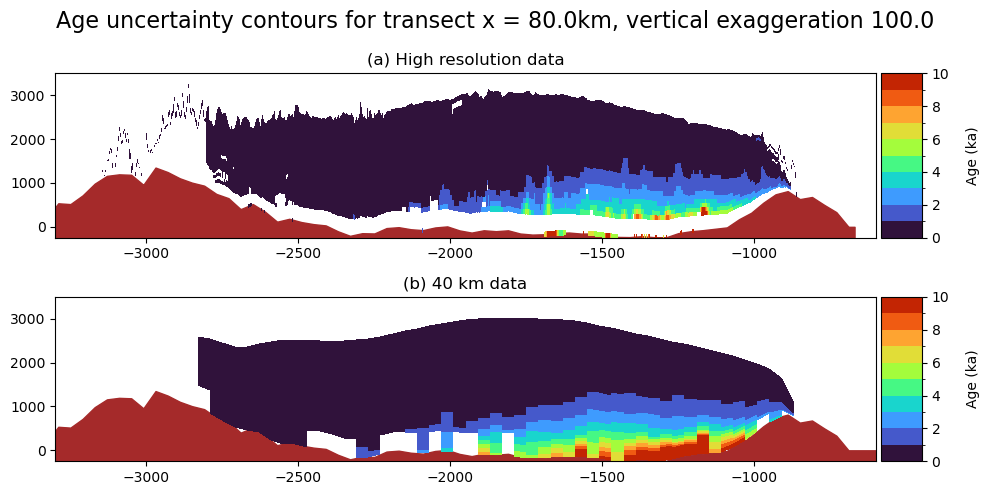

In [19]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(2, 1)

y_parallel_transect_idx = 20 # Corresponds to x = 80 km
y_parallel_transect_raw_data_idx = 712 # Corresponds to x = 80 km

x = ds_surfvel_data_40km['x'].data.copy()
y = ds_surfvel_data_40km['y'].data.copy()

zb = ds_bm5_40kms['zb'].data.copy()
H = ds_age_40kms['H'].data.copy()
age_c = ds_age_40kms['age_c'].data
age_c[age_c < 0.0] = np.nan
age_c_uncert = ds_age_40kms['age_c_uncert_unbounded'].data
age_c_uncert[age_c_uncert < 0.0] = np.nan
sigma_level_c = ds_age_40kms['sigma'].data.copy()

x_raw_data = ds_age_correct['xData'].data
y_raw_data = ds_age_correct['yData'].data
sigma_level_c_raw_data = np.arange(0., 1.+1/25.0, 1/25.0)
H_raw_data = ds_age_correct['H'].data

xMesh = np.tile(x[:, np.newaxis], sigma_level_c.shape[0]).T
yMesh = np.tile(y[:, np.newaxis], sigma_level_c.shape[0]).T
xMesh_raw_data = np.tile(x_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T
yMesh_raw_data = np.tile(y_raw_data[:, np.newaxis], sigma_level_c_raw_data.shape[0]).T

levels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

interp_func = interp1d(y, zb[:, y_parallel_transect_idx], kind='linear')
zb_interpolated = interp_func(y_raw_data)
z_coords = zb_interpolated + sigma_level_c_raw_data[:, np.newaxis]*H_raw_data[:, y_parallel_transect_raw_data_idx]

ax[0].fill_between(y_raw_data, zb_interpolated, -250, color='brown', alpha=1.0)
im = ax[0].pcolormesh(yMesh_raw_data, z_coords, ds_age_correct['age_c_uncert'][:, :, y_parallel_transect_raw_data_idx]/1000.0, cmap = cmap_disc, norm = norm)
ax[0].set_xlim(-3300, -600)
ax[0].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[0].set_title("(a) High resolution data")

levels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cm.get_cmap("turbo")
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Discrete colormap and normalization
cmap_disc = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, ncolors=len(colors))

ax[1].fill_between(y, zb[:, y_parallel_transect_idx], -250, color='brown', alpha=1.0)
z_coords = zb[:, y_parallel_transect_idx] + sigma_level_c[:, np.newaxis]*H[:, y_parallel_transect_idx]
im = ax[1].pcolormesh(yMesh, z_coords, age_c_uncert[:, :, y_parallel_transect_idx]/1000.0, cmap = cmap_disc, norm = norm)
ax[1].set_xlim(-3300, -600)
ax[1].set_ylim(-250, 3500)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax)
colorbar.set_label("Age (ka)", rotation=90, labelpad=12)
ax[1].set_title("(b) 40 km data")

fig.suptitle(f"Age uncertainty contours for transect x = {x_raw_data[y_parallel_transect_raw_data_idx]}km, vertical exaggeration 100.0", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/transect_x_80_uncert.png")

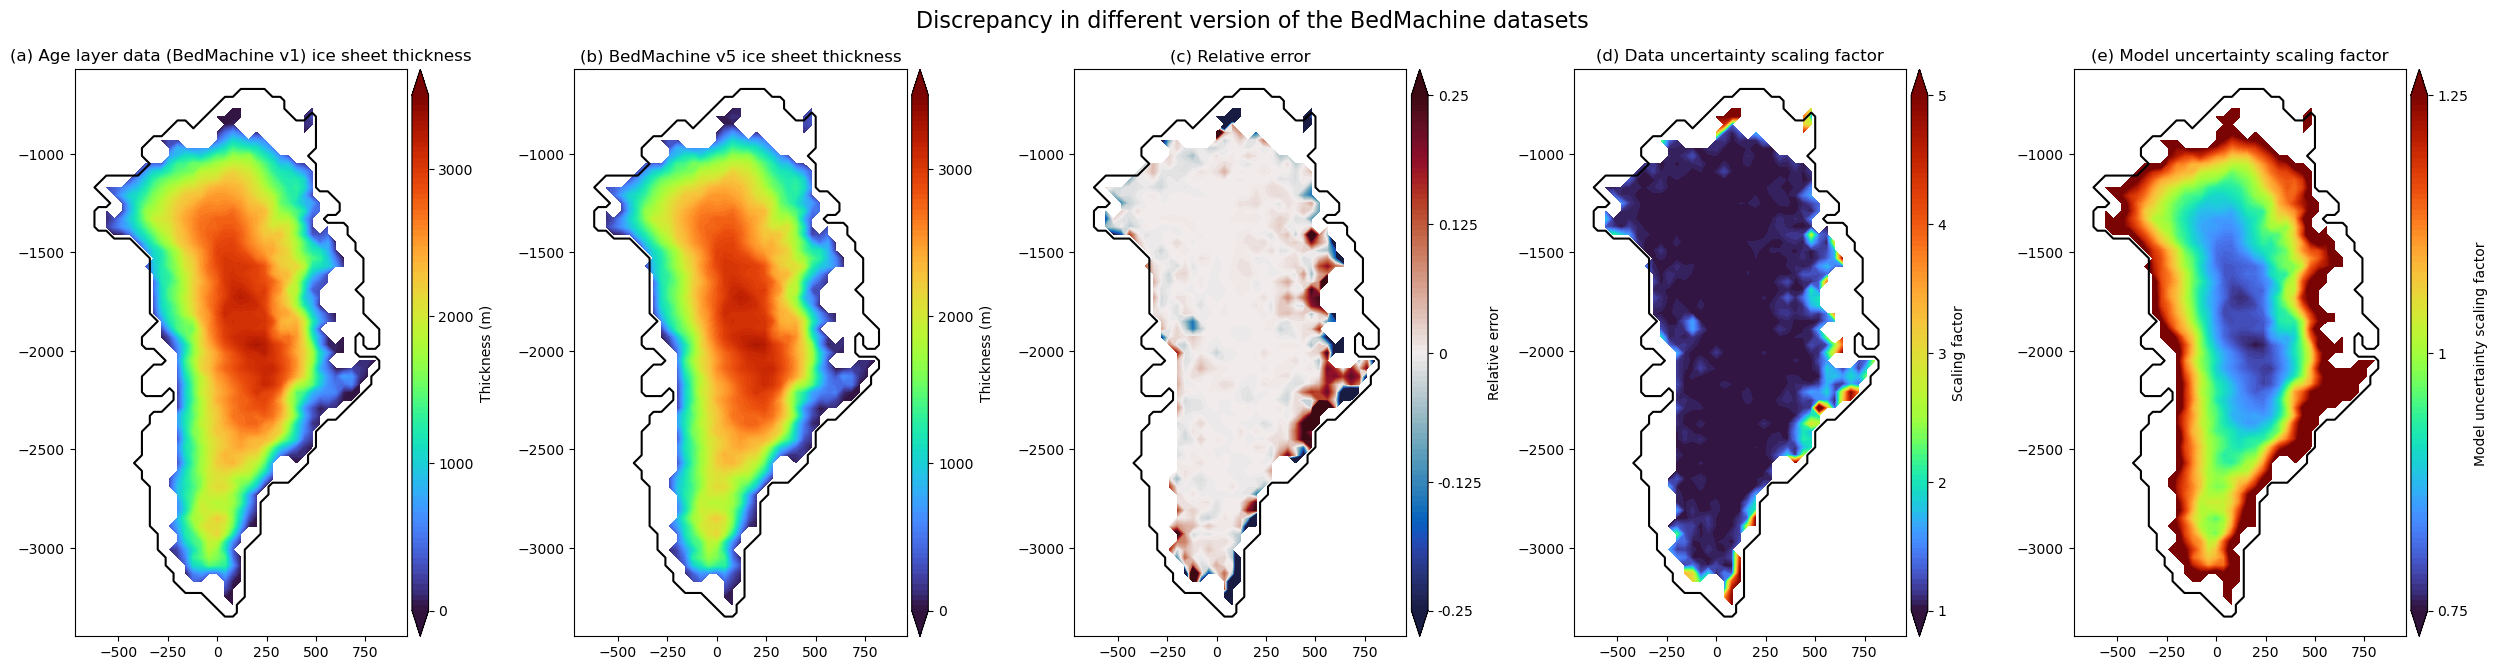

In [20]:
H_orig = ds_bm5_orig["H"].data.copy()

scale_uncert_factor_model = 1.0 - 0.25 * (H_orig - 2000.0) / (np.max(H_orig) - 2000.0)
scale_uncert_factor_data = 1 + 4.0 * np.abs((ds_age_40kms["H"].data / H_orig) - 1)
scale_uncert_factor_data = np.nan_to_num(scale_uncert_factor_data, nan=5)
scale_uncert_factor_data[scale_uncert_factor_data == 5.0] = np.nan
scale_uncert_factor_model[scale_uncert_factor_model == 1.393226] = np.nan

n_rows, n_cols = 1, 5
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.25)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

H_age_data_nan = ds_age_40kms['H'].data.copy()
H_age_data_nan[H_age_data_nan == 0] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                H_age_data_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[0],
                cbar_label = r"Thickness (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[0].set_title("(a) Age layer data (BedMachine v1) ice sheet thickness")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                H_data_nan,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 3500.0, center = 1750.0,
                fig = fig, ax = ax[1],
                cbar_label = r"Thickness (m)", cbar_ticks=[0.0, 1000.0, 2000.0, 3000.0])

ax[1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1].set_title("(b) BedMachine v5 ice sheet thickness")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                H_age_data_nan/H_data_nan - 1,
                cmap = cmo.balance, nbins = 100, vmin = -0.25, vmax = 0.25, center = 0.0,
                fig = fig, ax = ax[2],
                cbar_label = r"Relative error", cbar_ticks=[-0.25, -0.125, 0.0, 0.125, 0.25])

ax[2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[2].set_title("(c) Relative error")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                scale_uncert_factor_data,
                cmap = "turbo", nbins = 100, vmin = 1.0, vmax = 5.0, center = 2.5,
                fig = fig, ax = ax[3],
                cbar_label = r"Scaling factor", cbar_ticks=[1.0, 2.0, 3.0, 4.0, 5.0])

ax[3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[3].set_title("(d) Data uncertainty scaling factor")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                scale_uncert_factor_model,
                cmap = "turbo", nbins = 100, vmin = 0.75, vmax = 1.25, center = 1.0,
                fig = fig, ax = ax[4],
                cbar_label = r"Model uncertainty scaling factor", cbar_ticks=[0.75, 1.0, 1.25])

ax[4].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[4].set_title("(e) Model uncertainty scaling factor")

fig.suptitle(f"Discrepancy in different version of the BedMachine datasets", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/BM5_BM1_discrepancy.png")

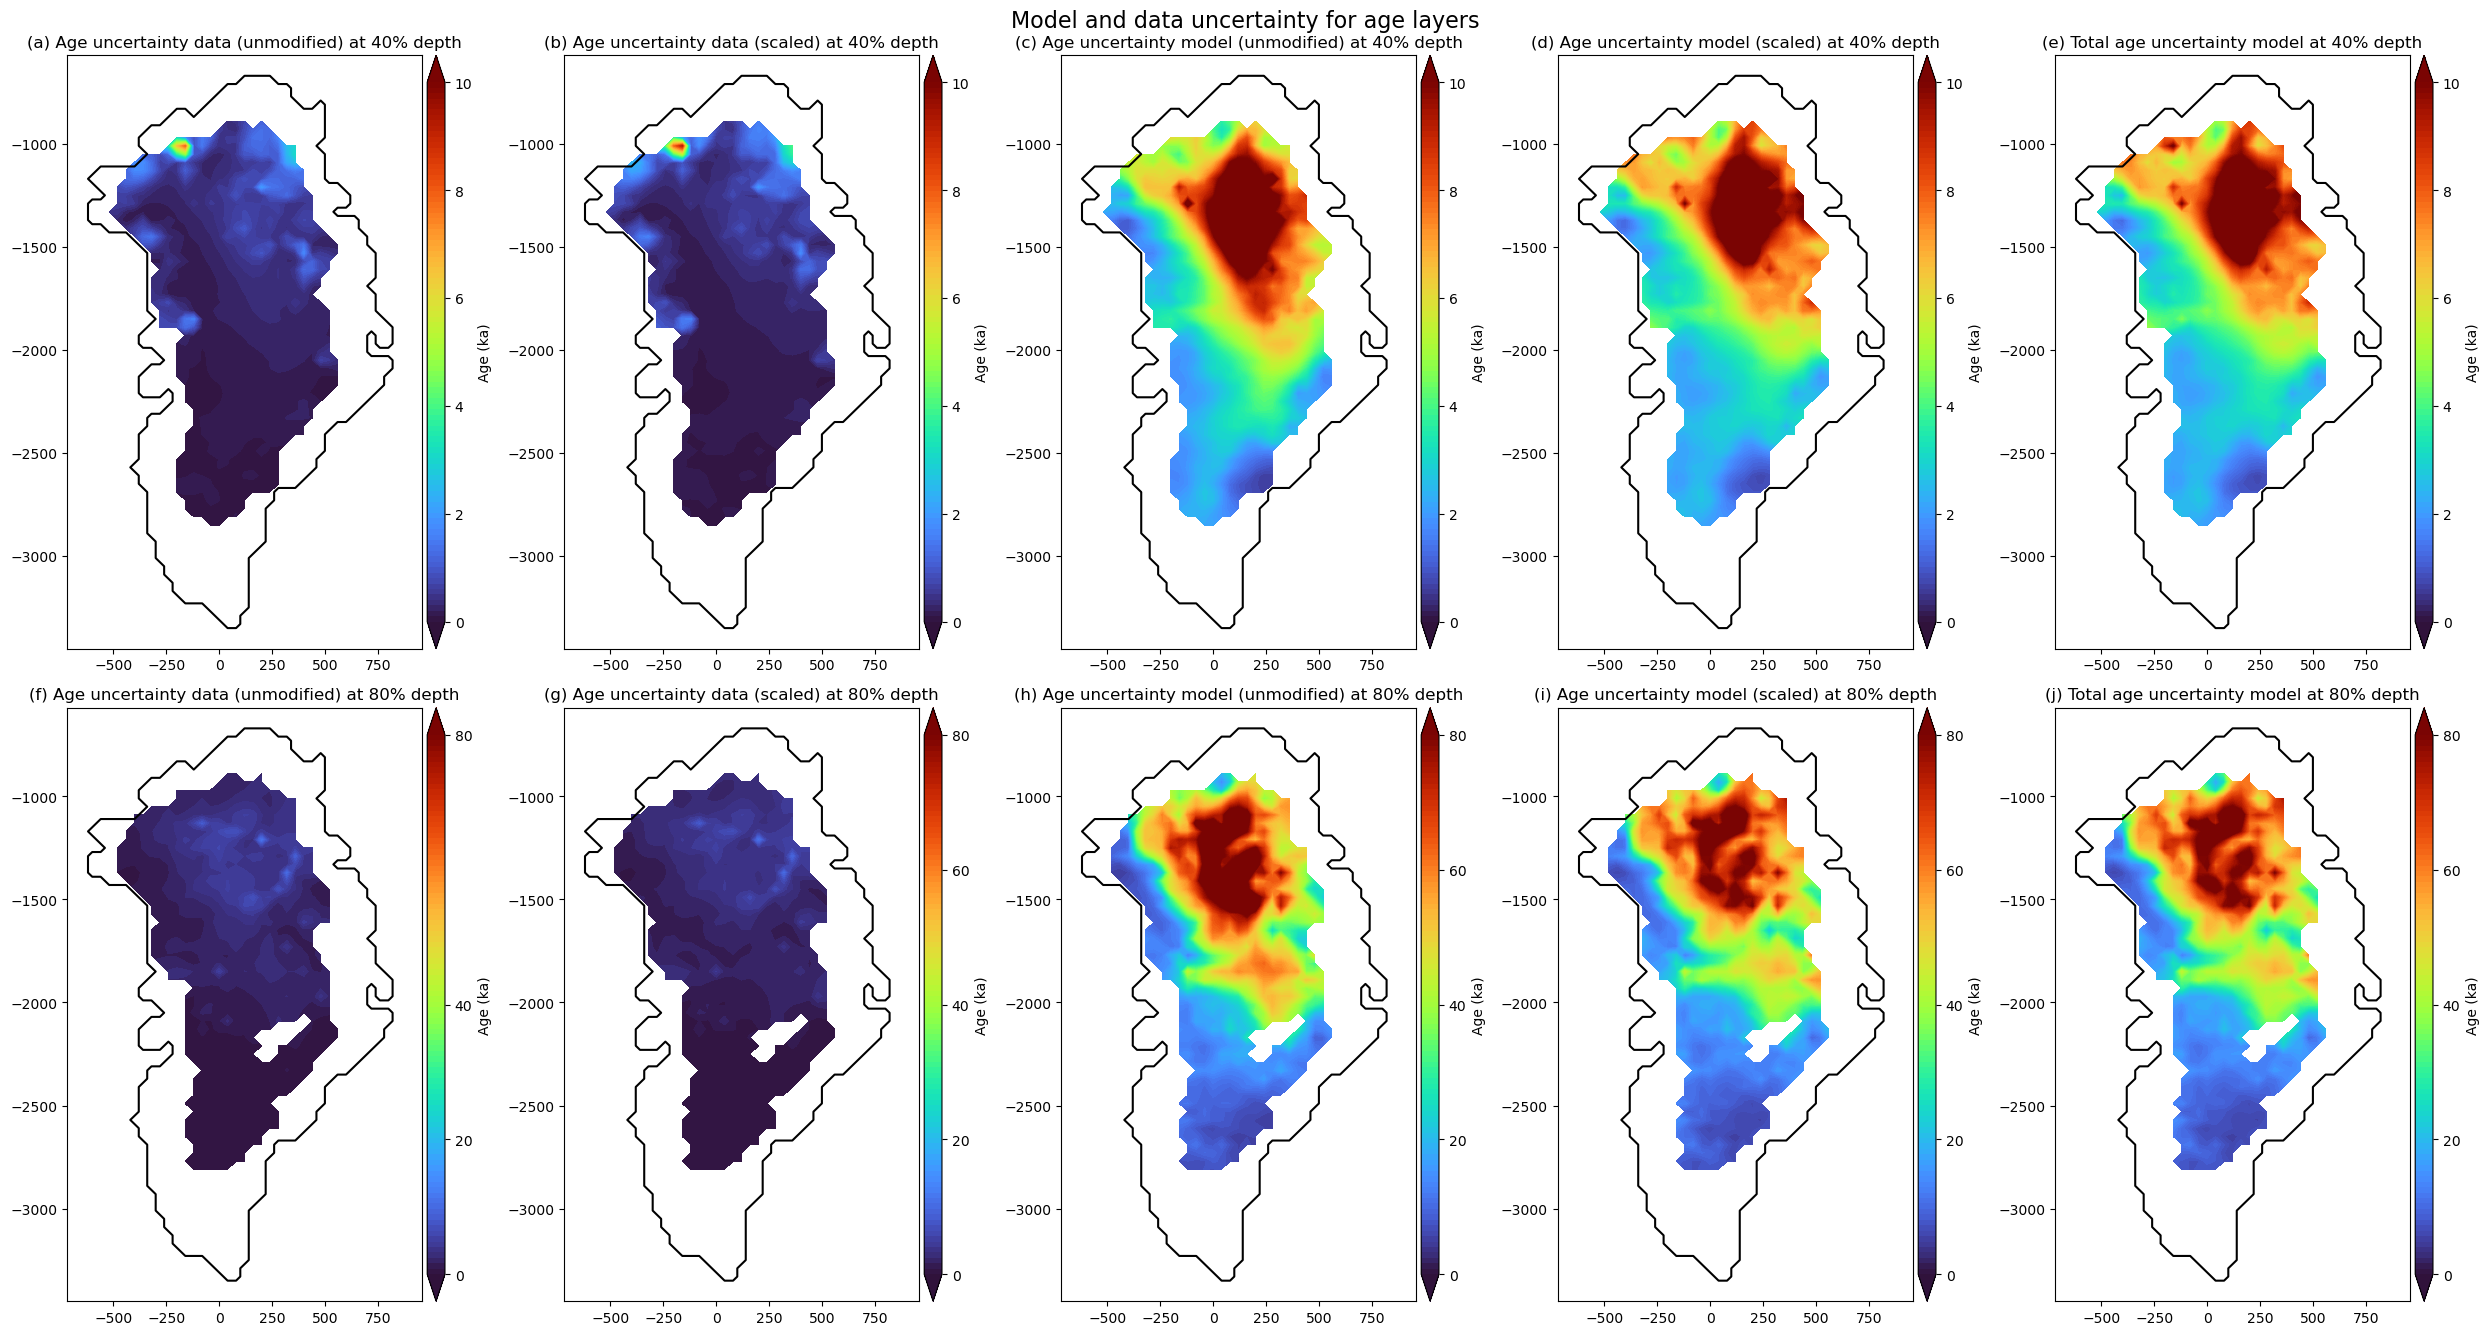

In [21]:
age_c_uncert_data = ds_age_40kms['age_c_uncert_unbounded'].data
age_c_uncert_model = ds_age_40kms['age_c'].data

scale_uncert_factor_model = 1.0 - 0.25 * (H_orig - 2000.0) / (np.max(H_orig) - 2000.0)
scale_uncert_factor_data = 1 + 4.0 * np.abs((ds_age_40kms["H"].data / H_orig) - 1)
scale_uncert_factor_data = np.nan_to_num(scale_uncert_factor_data, nan=5)

n_rows, n_cols = 2, 5
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.25)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 10.0, center = 5.0,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0, 8.0, 10.0])

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 0].set_title("(a) Age uncertainty data (unmodified) at 40% depth")

slice2d = slice_at_depth_linear(scale_uncert_factor_model*ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 10.0, center = 5.0,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0, 8.0, 10.0])

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 1].set_title("(b) Age uncertainty data (scaled) at 40% depth")


slice2d = slice_at_depth_linear(ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d >= 500000.0] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 10.0, center = 5.0,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0, 8.0, 10.0])

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 2].set_title("(c) Age uncertainty model (unmodified) at 40% depth")

slice2d = slice_at_depth_linear(scale_uncert_factor_model*ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d >= 500000.0] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 10.0, center = 5.0,
                fig = fig, ax = ax[0, 3],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0, 8.0, 10.0])

ax[0, 3].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 3].set_title("(d) Age uncertainty model (scaled) at 40% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d < 0.0] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 10.0, center = 5.0,
                fig = fig, ax = ax[0, 4],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0, 8.0, 10.0])

ax[0, 4].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 4].set_title("(e) Total age uncertainty model at 40% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 80.0, center = 40.0,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 20.0, 40.0, 80.0])

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 0].set_title("(f) Age uncertainty data (unmodified) at 80% depth")

slice2d = slice_at_depth_linear(scale_uncert_factor_model*ds_age_40kms['age_c_uncert_unbounded'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d < -1.e9] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 80.0, center = 40.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 20.0, 40.0, 60.0, 80.0])

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 1].set_title("(g) Age uncertainty data (scaled) at 80% depth")


slice2d = slice_at_depth_linear(ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d >= 500000.0] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 80.0, center = 40.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 20.0, 40.0, 60.0, 80.0])

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 2].set_title("(h) Age uncertainty model (unmodified) at 80% depth")

slice2d = slice_at_depth_linear(scale_uncert_factor_model*ds_age_40kms['age_c'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d >= 500000.0] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 80.0, center = 40.0,
                fig = fig, ax = ax[1, 3],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 20.0, 40.0, 60.0, 80.0])

ax[1, 3].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 3].set_title("(i) Age uncertainty model (scaled) at 80% depth")

slice2d = slice_at_depth_linear(ds_age_40kms['age_c_uncert'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d < 0.0] = np.nan

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 80.0, center = 40.0,
                fig = fig, ax = ax[1, 4],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 20.0, 40.0, 60.0, 80.0])

ax[1, 4].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 4].set_title("(j) Total age uncertainty model at 80% depth")

fig.suptitle(f"Model and data uncertainty for age layers", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/age_model_data_uncert.png")

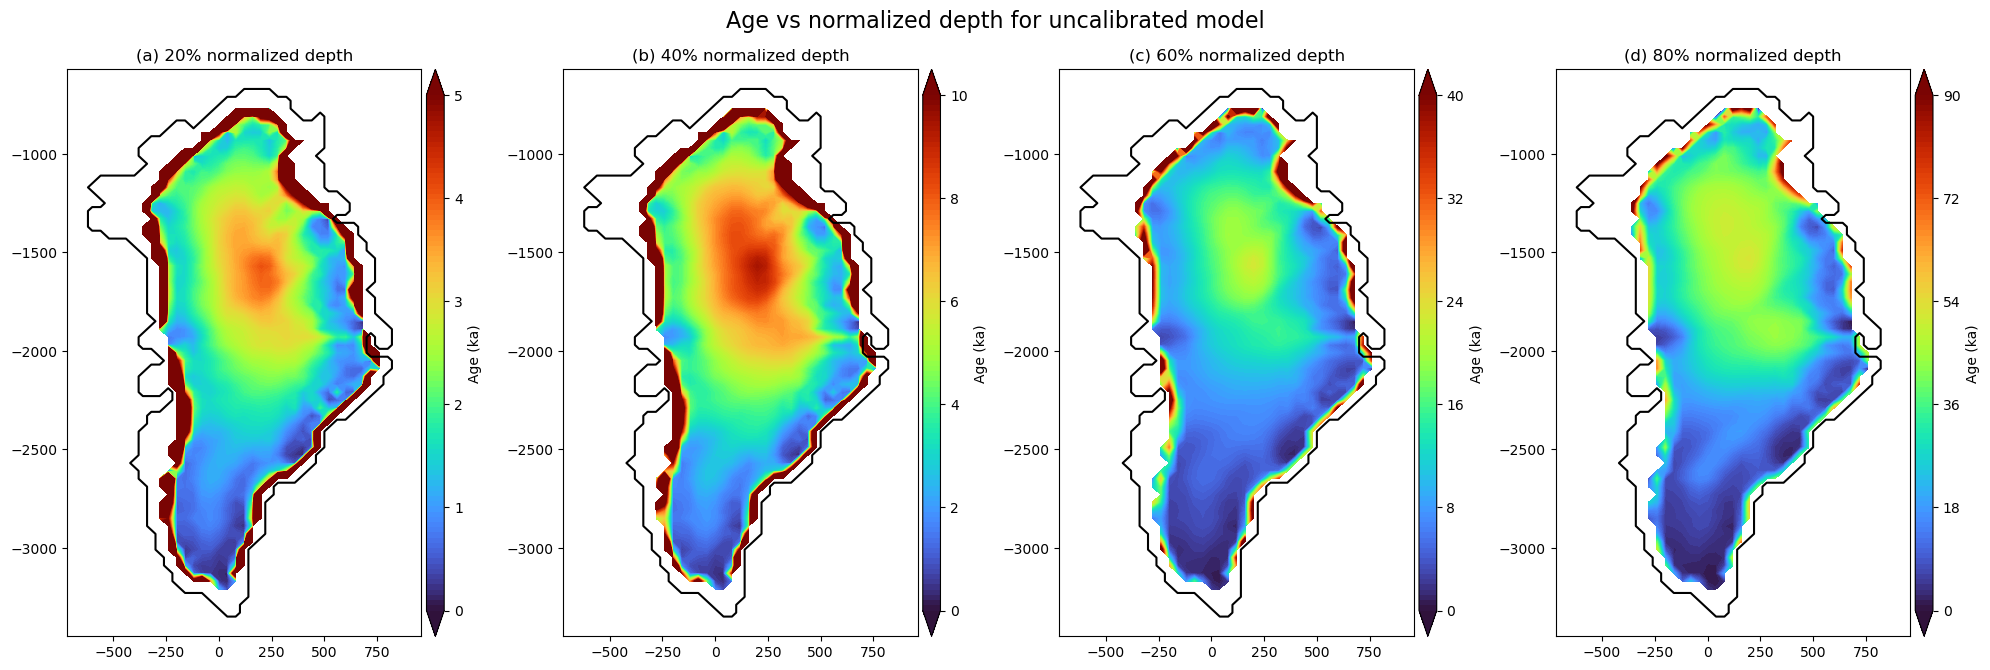

In [39]:
n_rows, n_cols = 1, 4
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

slice2d = slice_at_depth_linear(ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['age_c'].data, ds_age_40kms['sigma'].data, 0.8, return_weights=False)
slice2d[slice2d == 0.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 5.0, center = 2.5,
                fig = fig, ax = ax[0],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

ax[0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[0].set_title(f"(a) 20% normalized depth")

slice2d = slice_at_depth_linear(ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['age_c'].data, ds_age_40kms['sigma'].data, 0.6, return_weights=False)
slice2d[slice2d == 0.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 10.0, center = 5.0,
                fig = fig, ax = ax[1],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 2.0, 4.0, 6.0, 8.0, 10.0])

ax[1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[1].set_title(f"(b) 40% normalized depth")

slice2d = slice_at_depth_linear(ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['age_c'].data, ds_age_40kms['sigma'].data, 0.4, return_weights=False)
slice2d[slice2d == 0.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 40.0, center = 20.0,
                fig = fig, ax = ax[2],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 8.0, 16.0, 24.0, 32.0, 40.0])

ax[2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[2].set_title(f"(c) 60% normalized depth")

slice2d = slice_at_depth_linear(ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka['age_c'].data, ds_age_40kms['sigma'].data, 0.2, return_weights=False)
slice2d[slice2d == 0.0] = np.nan

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                slice2d / 1000.0,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 90.0, center = 45.0,
                fig = fig, ax = ax[3],
                cbar_label = r"Age (ka)", cbar_ticks=[0.0, 18.0, 36.0, 54.0, 72.0, 90.0])

ax[3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

ax[3].set_title(f"(d) 80% normalized depth")

fig.suptitle(f"Age vs normalized depth for uncalibrated model", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/age_normalized_depth_model.png")

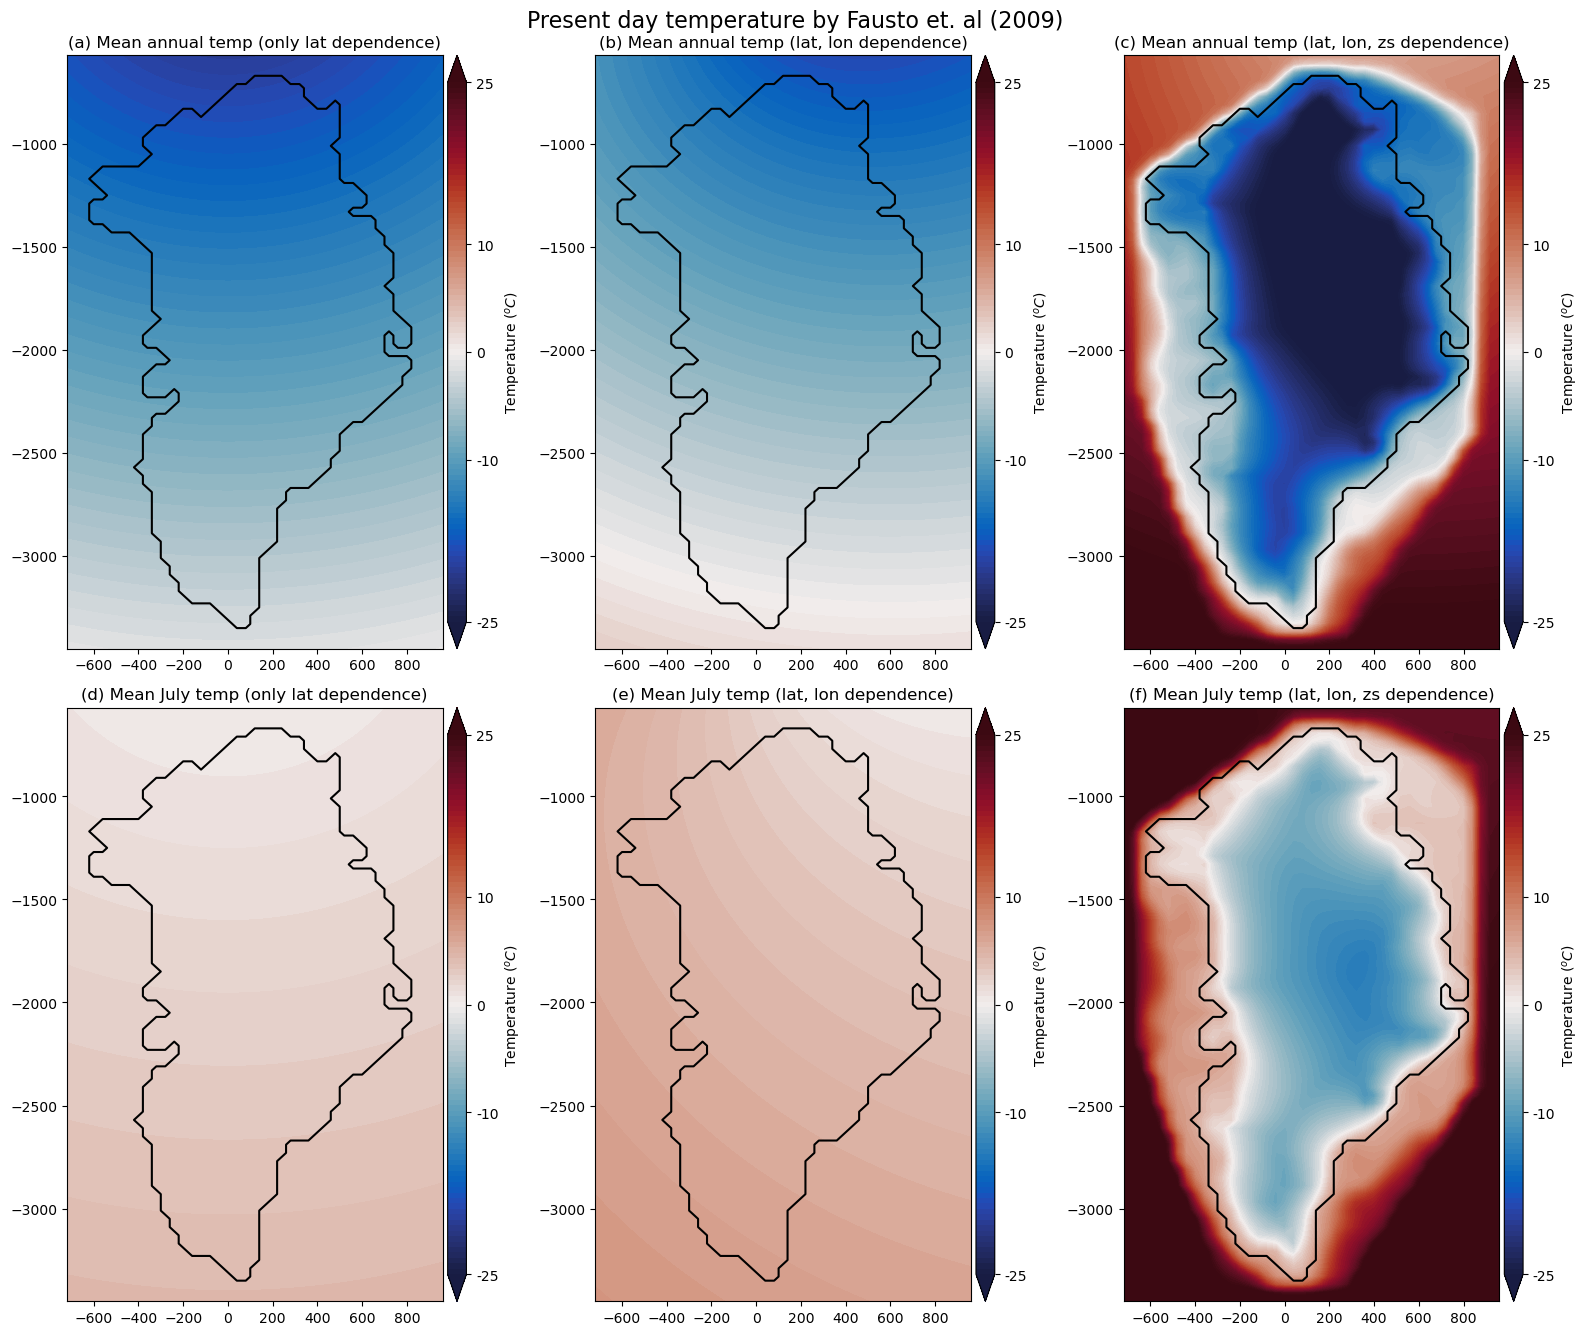

In [93]:
def compute_present_temps(zs, phi, lambda_, temp_present_offset=-1.0, type_ = "all"):
    """
    Vectorized translation of the Fortran snippet.
    Inputs are in radians for phi (latitude) and lambda_ (longitude).
    Returns temp_ma_present, temp_mj_present with the same shape as inputs.
    """
    # constants
    rad2deg = 180.0 / np.pi

    # Offsets
    theta_ma_offset = temp_present_offset
    theta_mj_offset = temp_present_offset

    # Mean-annual parameters
    theta_ma = 41.83 + theta_ma_offset
    gamma_ma = -6.309e-3
    c_ma     = -0.7189
    kappa_ma = -0.0672

    # Mean-July parameters
    theta_mj = 14.70 + theta_mj_offset
    gamma_mj = -5.426e-3
    c_mj     = -0.1585
    kappa_mj = -0.0518

    if type_ == "const":
        c_ma = 0.0
        gamma_ma = 0.0
        kappa_ma = 0.0
        c_mj = 0.0
        gamma_mj = 0.0
        kappa_mj = 0.0        
    elif type_ == "only_lat":
        gamma_ma = 0.0
        kappa_ma = 0.0
        gamma_mj = 0.0
        kappa_mj = 0.0
    elif type_ == "lat_lon":
        gamma_ma = 0.0
        gamma_mj = 0.0
    elif type_ == "all":
        pass
    else:
        raise ValueError("Wrong type_")

    # Map longitude to (-π, π] like Fortran: modulo(lambda+π, 2π) - π
    lon_term = np.mod(lambda_ + np.pi, 2*np.pi) - np.pi

    # Present-day mean-annual air temperature
    temp_ma_present = (
        theta_ma
        + gamma_ma * zs
        + c_ma * phi * rad2deg
        + kappa_ma * lon_term * rad2deg
    )

    # Present-day mean-July (mid-summer) air temperature
    temp_mj_present = (
        theta_mj
        + gamma_mj * zs
        + c_mj * phi * rad2deg
        + kappa_mj * lon_term * rad2deg
    )

    return temp_ma_present, temp_mj_present

lambda_ = ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka["lambda"].data.copy()
phi = ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka["phi"].data.copy()
zs = ds_grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka["zs"].data.copy()


n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

temp_ma_present, temp_mj_present = compute_present_temps(zs, phi, lambda_, temp_present_offset=-1.0, type_="only_lat")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                temp_ma_present,
                cmap = cmo.balance, nbins = 100, vmin = -25.0, vmax = 25.0, center = 0.0,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Temperature ($^{o}C$)", cbar_ticks=[-25.0, -10.0, 0.0, 10.0, 25.0])

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 0].set_title(f"(a) Mean annual temp (only lat dependence)")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                temp_mj_present,
                cmap = cmo.balance, nbins = 100, vmin = -25.0, vmax = 25.0, center = 0.0,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Temperature ($^{o}C$)", cbar_ticks=[-25.0, -10.0, 0.0, 10.0, 25.0])

ax[1, 0].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 0].set_title(f"(d) Mean July temp (only lat dependence)")

temp_ma_present, temp_mj_present = compute_present_temps(zs, phi, lambda_, temp_present_offset=-1.0, type_="lat_lon")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                temp_ma_present,
                cmap = cmo.balance, nbins = 100, vmin = -25.0, vmax = 25.0, center = 0.0,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Temperature ($^{o}C$)", cbar_ticks=[-25.0, -10.0, 0.0, 10.0, 25.0])

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 1].set_title(f"(b) Mean annual temp (lat, lon dependence)")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                temp_mj_present,
                cmap = cmo.balance, nbins = 100, vmin = -25.0, vmax = 25.0, center = 0.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Temperature ($^{o}C$)", cbar_ticks=[-25.0, -10.0, 0.0, 10.0, 25.0])

ax[1, 1].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 1].set_title(f"(e) Mean July temp (lat, lon dependence)")

temp_ma_present, temp_mj_present = compute_present_temps(zs, phi, lambda_, temp_present_offset=-1.0, type_="all")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                temp_ma_present,
                cmap = cmo.balance, nbins = 100, vmin = -25.0, vmax = 25.0, center = 0.0,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Temperature ($^{o}C$)", cbar_ticks=[-25.0, -10.0, 0.0, 10.0, 25.0])

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0, 2].set_title(f"(c) Mean annual temp (lat, lon, zs dependence)")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                temp_mj_present,
                cmap = cmo.balance, nbins = 100, vmin = -25.0, vmax = 25.0, center = 0.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Temperature ($^{o}C$)", cbar_ticks=[-25.0, -10.0, 0.0, 10.0, 25.0])

ax[1, 2].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1, 2].set_title(f"(f) Mean July temp (lat, lon, zs dependence)")

fig.suptitle(f"Present day temperature by Fausto et. al (2009)", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/present_day_temperature.png")

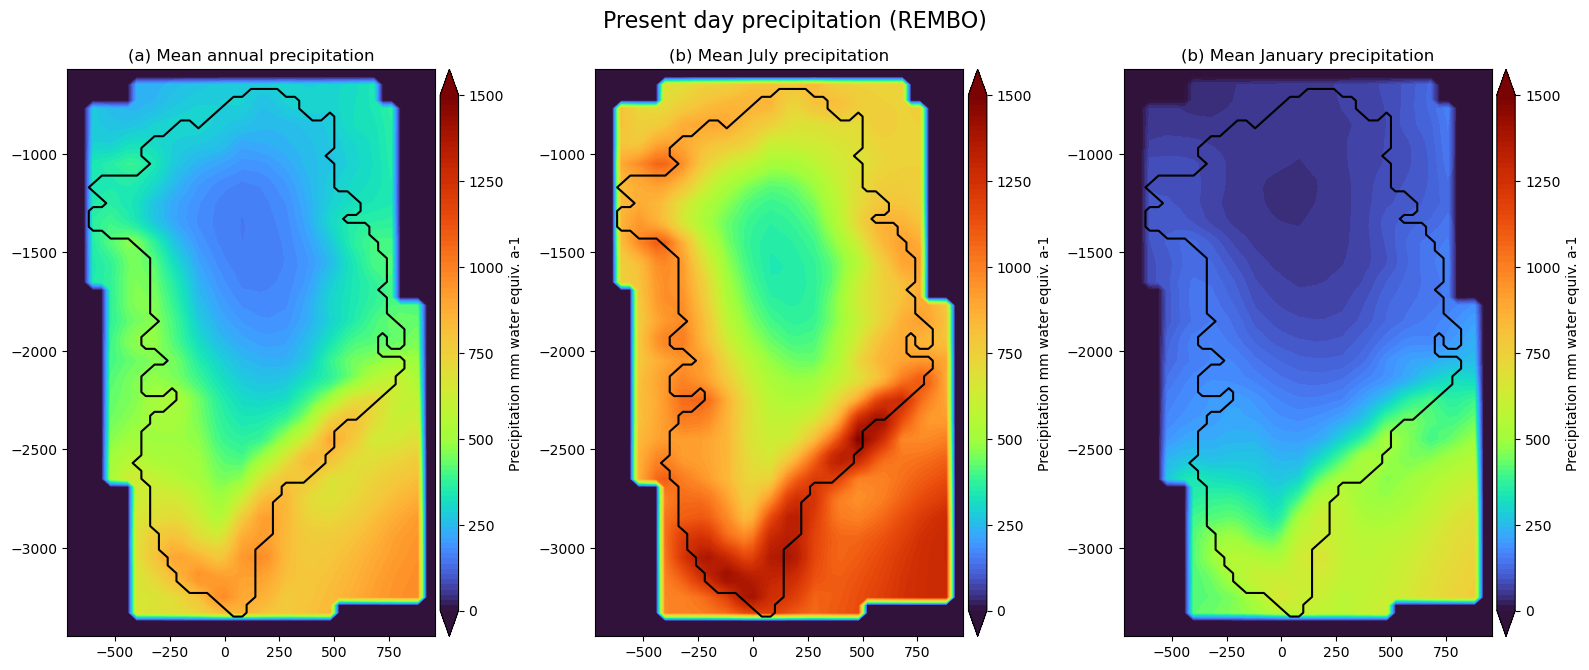

In [96]:
n_rows, n_cols = 1, 3
aspect_ratio = len(ds_surfvel_model_40km_tuned['x'])/len(ds_surfvel_model_40km_tuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                precip["precip_ma_present"].data,
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1500.0, center = 500.0,
                fig = fig, ax = ax[0],
                cbar_label = r"Precipitation mm water equiv. a-1", cbar_ticks=[0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0])

ax[0].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[0].set_title(f"(a) Mean annual precipitation")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                precip["precip_present"].data[6],
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1500.0, center = 500.0,
                fig = fig, ax = ax[1],
                cbar_label = r"Precipitation mm water equiv. a-1", cbar_ticks=[0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0])

ax[1].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[1].set_title(f"(b) Mean July precipitation")

plot_normal_new(ds_age_40kms['x'], 
                ds_age_40kms['y'], 
                precip["precip_present"].data[0],
                cmap = "turbo", nbins = 100, vmin = 0.0, vmax = 1500.0, center = 500.0,
                fig = fig, ax = ax[2],
                cbar_label = r"Precipitation mm water equiv. a-1", cbar_ticks=[0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0])

ax[2].contour(ds_surfvel_data_40km['x'], 
              ds_surfvel_data_40km['y'],
              mask_land_tuned, levels=[0], colors="black")

ax[2].set_title(f"(b) Mean January precipitation")

fig.suptitle(f"Present day precipitation (REMBO)", fontsize = 16)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_5/present_day_precipitation.png")